#**UNDERSTANDING THE DATA**

##0.REFERENCE

https://claude.ai/share/203b5b43-e1cb-4b85-8da9-89579c134e0c

##1.CONTEXT



**Introduction**

Market data is the raw material of algorithmic trading. Before we can build signals, construct portfolios, or deploy machine learning models, we must understand what market data *is*, how it's structured, what can go wrong with it, and how its fundamental properties shape everything we build on top.

This notebook takes a pedagogical approach that differs from most quantitative finance tutorials: **we generate all our data from scratch**. Rather than downloading historical prices and hoping they illustrate the concepts we need, we explicitly encode those concepts into synthetic data-generating processes (DGPs). This approach has several advantages:

1. **Clarity of ground truth**: We know exactly what's "true" in our simulated world because we encoded it ourselves. When we say "volatility clusters," we can point to the exact mechanism in our DGP that creates it.

2. **Pedagogical control**: We can dial parameters up or down to see effects clearly. Want to see what happens when volatility clustering is weak vs strong? Just change a parameter. Real market data doesn't offer this luxury.

3. **Reproducibility**: Every student running this notebook will see identical results (same random seed). This makes debugging, discussion, and learning far more effective than working with live data that changes daily.

4. **No dependencies on external APIs**: You don't need API keys, data subscriptions, or worry about rate limits. Everything runs purely from code you can inspect and modify.

5. **Foundation for later chapters**: When we move to machine learning and backtesting, we'll build on these same DGPs. You'll be able to test strategies on data where you *know* whether a signal should exist or not.

**What This Notebook Covers**

We work through the core concepts from Chapter 02 of "AI and Algorithmic Trading":

**1. The Market Data Tensor**  
Market data is inherently multi-dimensional. We need to track prices, volumes, and other attributes across multiple assets over time at various resolutions (daily, intraday, tick-by-tick). We'll represent this "tensor" using pure Python data structures: lists, dictionaries, and tuples. No pandas. No DataFrame magic. Just explicit, transparent code you can reason about from first principles.

**2. Price Definitions and Return Calculations**  
What seems simple—"the return from yesterday to today"—hides important choices. Simple returns vs log returns. Raw returns vs excess returns. Single-period vs multi-period. We'll implement each definition cleanly in pure Python and visualize the differences.

**3. Volume, Liquidity, and Microstructure**  
Volume is not just a number—it's a window into market microstructure. High volume often accompanies high volatility. Intraday volume follows predictable patterns (the famous U-shaped curve). We'll generate synthetic volume data that respects these empirical regularities and show how to measure and visualize them.

**4. Stylised Facts of Financial Returns**  
Real financial returns exhibit robust statistical properties that appear across assets, markets, and time periods:
- **Fat tails**: Extreme events happen more often than Gaussian models predict
- **Volatility clustering**: Large moves beget large moves (of either sign)
- **Cross-sectional dependence**: Assets don't move independently

We'll generate data that exhibits these properties and show how to detect and quantify them using pure Python implementations of skewness, kurtosis, autocorrelation, and cross-correlation.

**5. Data Quality, Cleaning, and Missing Data**  
Real-world data is messy. Prices can have outliers (bad ticks), gaps (missing observations), and other errors. We'll intentionally corrupt our clean synthetic data to simulate these problems, then implement cleaning heuristics (z-score filtering, interpolation, forward-fill) and show their trade-offs.

**6. Implications for Feature Engineering and ML**  
Everything we learn about data structure and quality has downstream consequences for modeling. We'll show how to construct features that respect causality (no look-ahead bias), split data temporally (not randomly), normalize using only past information, and set up the foundation for the machine learning pipelines we'll build in later chapters.

**Why No Pandas?**

This notebook is part of the **Synthetic Data Lab** track of our course, where we privilege understanding over convenience. Pandas is a powerful library, but its abstractions can hide what's actually happening to your data. By working with lists and dictionaries, you'll:

- Understand exactly how each operation works (no magic)
- Develop intuition for computational complexity and memory usage
- Build skills that transfer to any programming environment
- See clearly what pandas is doing under the hood when you eventually use it

We use minimal numpy (for random number generation and linear algebra) and matplotlib (for plotting), but all data manipulation is explicit Python code you can trace line by line.

**Structure of This Notebook**

The notebook is organized into 8 main sections:

1. **Setup and Synthetic Data Generation**: Define DGPs and generate our universe
2. **Market Data as a Structured Object**: Explore different representations
3. **Price Definitions and Returns**: Implement return calculations from scratch
4. **Volume, Liquidity, and Microstructure**: Analyze volume patterns
5. **Stylised Facts**: Verify fat tails, volatility clustering, correlations
6. **Data Quality and Cleaning**: Inject errors and implement cleaning
7. **Feature Engineering and ML Implications**: Build features properly
8. **Practical Checklist**: Real-world data quality considerations

**How to Use This Notebook**

**For students**: Run each cell sequentially. Read the markdown explanations before each code block. Experiment by changing parameters in the DGPs—what happens if you increase volatility clustering? Reduce correlation between assets? Add more jumps?

**For instructors**: Use this as a template. The modular design lets you extract sections for homework problems. The explicit DGPs make it easy to create variations for exams or projects.

**For practitioners**: Even if you work with real data, understanding these DGPs will sharpen your intuition. When you see fat tails in production data, you'll immediately connect it to the kurtosis calculations we implement here. When backtests fail due to look-ahead bias, you'll recognize it because we showed you the right way to construct features.

**A Note on Synthetic vs Real Data**

Some might ask: "Why bother with synthetic data? Why not just download real market data?" The answer is that synthetic and real data serve different pedagogical purposes:

- **Synthetic data** (this notebook) is ideal for learning *concepts*. It isolates one phenomenon at a time, lets you control parameters, and provides ground truth.

- **Real data** is essential for learning about *reality*. It's messier, more surprising, and humbling. It teaches you that markets don't follow textbook models.

Think of synthetic data as a flight simulator. You practice basic maneuvers in a controlled environment where you can crash without consequences. Real data is the actual flight—unpredictable, risky, essential. You need both.

In later chapters, when we've built intuition here, we'll move to real market data and see how our tools perform when the DGP is unknown, non-stationary, and full of surprises.

**Prerequisites**

To get the most from this notebook, you should have:

- Basic Python programming skills (functions, loops, lists, dictionaries)
- Familiarity with elementary statistics (mean, variance, correlation)
- Some exposure to financial concepts (what a stock price is, what returns mean)
- Willingness to read code carefully and experiment with parameters

You don't need to be a mathematician or a professional quant. We build everything from first principles and explain each step.


By the end of this notebook, you will be able to:

1. **Generate realistic synthetic market data** with controlled properties
2. **Implement return calculations** (simple, log, excess, multi-period) in pure Python
3. **Detect and quantify stylised facts** (fat tails, volatility clustering, correlations)
4. **Identify and clean data quality issues** (outliers, gaps, stale prices)
5. **Build features that respect temporal causality** and avoid look-ahead bias
6. **Set up proper ML pipelines** with time-aware train/test splits and normalization
7. **Articulate the trade-offs** in data representation, cleaning, and preprocessing choices

These skills form the foundation for everything that follows: factor models, classical time series methods, machine learning, deep learning, and reinforcement learning. You can't build robust trading systems on shaky data foundations.

**The Philosophy of This Course**

This notebook embodies the core philosophy of the "AI and Algorithmic Trading" course and its companion Synthetic Data Lab:

**1. First principles over black boxes**  
We implement algorithms ourselves before using libraries. This builds deep understanding and makes you dangerous—you can debug anything, build custom solutions, and aren't limited by what existing tools provide.

**2. Explicit over implicit**  
We make assumptions visible. When we generate data, you see exactly what went into it. When we compute statistics, you see every step. There's no "magic" happening behind the scenes.

**3. Pedagogical over production**  
This code prioritizes clarity over performance. Real production systems use pandas, numba, and other optimizations. We use lists and loops because they're transparent. Once you understand what's happening, you can optimize.

**4. Skepticism over faith**  
We question everything. Why this return definition? What happens if data is missing? How do we know our features don't leak future information? Healthy skepticism is essential in quantitative finance where subtle mistakes can be expensive.

**5. Experimentation over memorization**  
We don't just show you results—we give you the tools to explore. Change parameters. Break things. See what happens. This is how you develop intuition.


Let's dive in. We'll start by importing our minimal set of libraries and building the functions that will generate our synthetic market universe. Every price series, every volume tick, every return will be something we created ourselves—transparent, reproducible, and pedagogically optimal.

Markets are complex, but understanding market *data* starts with simple, explicit building blocks. That's what we're building today.



## 2.LIBRARIES AND ENVIRONMENT

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, log, exp
import random
from datetime import datetime, timedelta

## 3.SYNTHETIC DATA GENERATION

###3.1.OVERVIEW



This section builds the foundation for everything that follows. We define data-generating processes (DGPs) that create realistic synthetic market data with controlled, known properties.

**Why Generate Our Own Data?**

When you download real market data, you're working blind. You don't know the true data-generating process. You don't know if patterns you observe are signal or noise. You can't rewind time and change parameters to test hypotheses. Synthetic data solves all these problems. We explicitly encode the properties we want to study—drift, volatility, clustering, jumps—and then observe how they manifest in the resulting time series.

**What We're Building**

We'll create a small universe of four synthetic assets over 750 trading days (~3 years):

- **STOCK_A**: Large-cap tech style with high volatility, GARCH-like clustering, and occasional jumps
- **STOCK_B**: Large-cap consumer style with moderate volatility and clustering
- **INDEX_ETF**: Broad market index with lower volatility, strong clustering, no jumps
- **FX_PROXY**: Currency pair with low volatility, minimal clustering

Each asset will have complete OHLCV (Open, High, Low, Close, Volume) data generated from first principles.

**The Core DGP: Geometric Brownian Motion with Extensions**

Our base model is GBM: prices evolve as exponentials of cumulative returns, where returns have drift (μ) and volatility (σ). We extend this with stochastic volatility (GARCH-style clustering) and jump processes to match real market stylized facts.

**Implementation Strategy**

We'll write pure Python functions that take economic parameters as inputs and return lists of prices, returns, volumes, and dates. No external dependencies except numpy for random number generation. Everything is transparent, modifiable, and reproducible.

This explicit construction teaches you what market data *is* at a fundamental level—not just numbers in a table, but the output of stochastic processes you can understand, modify, and control.

###3.2.CODE AND IMPLEMENTATION

Core libraries imported.
Working with: lists, dicts, tuples, and minimal numpy
Data generation functions defined.
Generating 750 days of synthetic data for 4 assets...
  Generating STOCK_A...
  Generating STOCK_B...
  Generating INDEX_ETF...
  Generating FX_PROXY...
Synthetic market data generation complete!
Each asset has 750 daily observations
Structure of market_data['STOCK_A']:
  Keys: ['dates', 'prices', 'returns', 'volumes', 'ohlc', 'params']

  dates: list of 750 date strings
    First 5: ['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08']

  prices: list of 750 floats
    First 5: [150.0, 151.28, 151.05, 150.65, 150.31]

  returns: list of 750 floats (first is None)
    First 5: [None, 0.008512, -0.001551, -0.002619, -0.002309]

  volumes: list of 750 ints
    First 5: [13988742, 12718950, 13197337, 13426048, 11888865]

  ohlc: list of 750 dicts
    First entry: {'open': 149.95198620285834, 'high': 151.82296980151185, 'low': 148.1290164013465, 'close': 150.0}

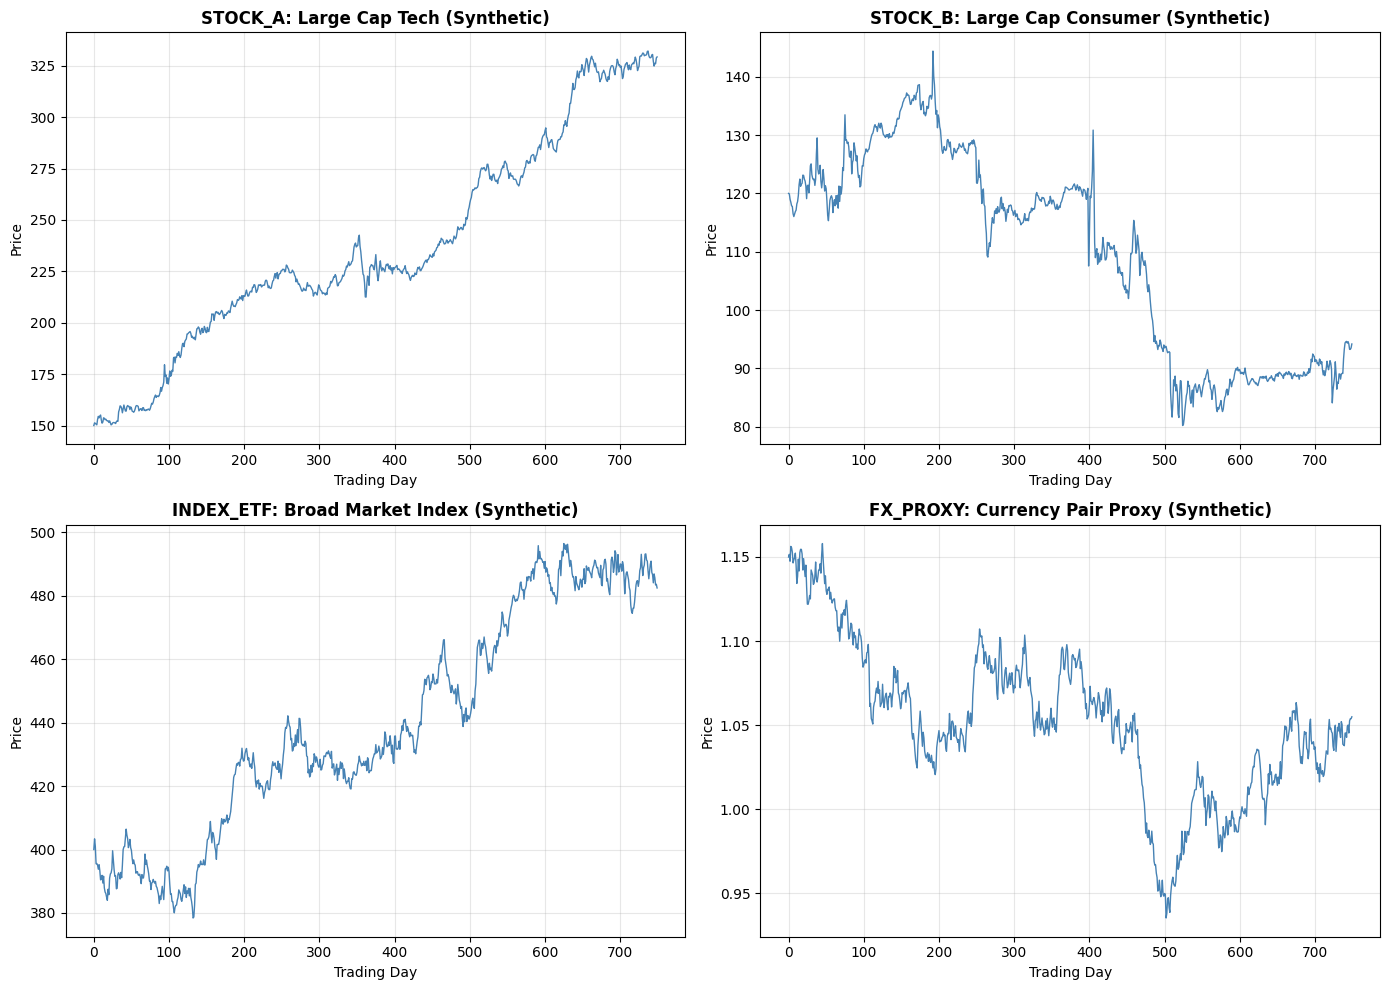


Synthetic price paths generated successfully!
Note the realistic features:
  - Drift (upward trend)
  - Volatility (noise)
  - Occasional jumps (STOCK_A, STOCK_B)
  - Different scales (equity vs FX)


In [ ]:

# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)

print("Core libraries imported.")
print("Working with: lists, dicts, tuples, and minimal numpy")

# %% [markdown]
# ### 1.1 Data Generation Functions
#
# Let's build functions to generate synthetic price series with realistic
# properties that mirror actual market data.

# %% [code]
def generate_price_series(n_days, initial_price, daily_mu, daily_sigma,
                          vol_clustering=True, jumps=False):
    """
    Generate a synthetic daily price series using Geometric Brownian Motion
    with optional stochastic volatility and jumps.

    Parameters:
    -----------
    n_days : int
        Number of trading days to simulate
    initial_price : float
        Starting price (e.g., 100.0)
    daily_mu : float
        Daily drift (mean return), e.g., 0.0005 for 0.05% per day
    daily_sigma : float
        Daily volatility (std of returns), e.g., 0.02 for 2% per day
    vol_clustering : bool
        If True, use GARCH-like volatility clustering
    jumps : bool
        If True, add occasional price jumps

    Returns:
    --------
    prices : list of float
        Daily prices
    returns : list of float
        Daily log returns (first element is None)
    dates : list of str
        Synthetic date strings
    """
    prices = [initial_price]
    returns = [None]  # First return is undefined

    # Start date
    start_date = datetime(2021, 1, 4)  # A Monday
    dates = [start_date.strftime('%Y-%m-%d')]

    # If using volatility clustering, initialize volatility process
    if vol_clustering:
        # GARCH(1,1)-like parameters
        omega = 0.000001
        alpha = 0.15
        beta = 0.80
        vol_t = daily_sigma
    else:
        vol_t = daily_sigma

    for t in range(1, n_days):
        # Current volatility
        if vol_clustering:
            # Update volatility based on previous return
            prev_return = returns[-1] if returns[-1] is not None else 0.0
            vol_t = sqrt(omega + alpha * (prev_return ** 2) + beta * (vol_t ** 2))
            vol_t = max(vol_t, daily_sigma * 0.3)  # Floor
            vol_t = min(vol_t, daily_sigma * 3.0)  # Ceiling

        # Generate return
        z = np.random.randn()
        ret = daily_mu + vol_t * z

        # Add jumps occasionally
        if jumps and np.random.rand() < 0.01:  # 1% chance per day
            jump_size = np.random.randn() * daily_sigma * 3
            ret += jump_size

        # Update price
        new_price = prices[-1] * exp(ret)
        prices.append(new_price)
        returns.append(ret)

        # Create date (skip weekends for realism)
        current_date = start_date + timedelta(days=t)
        # If weekend, skip to Monday
        while current_date.weekday() >= 5:  # Saturday=5, Sunday=6
            current_date += timedelta(days=1)
        dates.append(current_date.strftime('%Y-%m-%d'))

    return prices, returns, dates


def generate_volume_series(returns, base_volume, vol_sensitivity=2.0):
    """
    Generate synthetic volume data correlated with absolute returns.

    Parameters:
    -----------
    returns : list of float
        Return series (with None at index 0)
    base_volume : float
        Average daily volume (e.g., 10_000_000 shares)
    vol_sensitivity : float
        How strongly volume responds to volatility (higher = stronger)

    Returns:
    --------
    volumes : list of int
        Daily volume (in shares)
    """
    volumes = []
    for ret in returns:
        if ret is None:
            # First day: use base volume
            vol = int(base_volume * (1 + 0.2 * np.random.randn()))
        else:
            # Volume increases with |return|
            abs_ret = abs(ret)
            multiplier = 1 + vol_sensitivity * abs_ret + 0.3 * np.random.randn()
            multiplier = max(multiplier, 0.2)  # Floor
            vol = int(base_volume * multiplier)

        volumes.append(max(vol, 1000))  # At least 1000 shares

    return volumes


def generate_ohlc_from_close(close_prices, daily_vol):
    """
    Generate synthetic OHLC data from close prices.
    Assumes intraday range is related to daily volatility.

    Parameters:
    -----------
    close_prices : list of float
        Daily close prices
    daily_vol : float
        Daily volatility (for scaling intraday range)

    Returns:
    --------
    ohlc : list of dict
        Each dict has keys: 'open', 'high', 'low', 'close'
    """
    ohlc = []
    for i, close in enumerate(close_prices):
        # Intraday range as fraction of price
        intraday_range = close * daily_vol * np.random.uniform(0.5, 1.5)

        # Open near previous close (with some gap)
        if i == 0:
            open_price = close * (1 + 0.001 * np.random.randn())
        else:
            prev_close = close_prices[i-1]
            gap = 0.005 * np.random.randn()  # Overnight gap
            open_price = prev_close * (1 + gap)

        # High and low bracket the close and open
        high = max(open_price, close) + intraday_range * 0.5
        low = min(open_price, close) - intraday_range * 0.5

        ohlc.append({
            'open': open_price,
            'high': high,
            'low': low,
            'close': close
        })

    return ohlc


print("Data generation functions defined.")

# %% [markdown]
# ### 1.2 Generate Synthetic Universe
#
# We'll create a small universe of 4 synthetic assets to explore the
# multi-dimensional nature of the market data tensor.

# %% [code]
# Define our synthetic universe
n_days = 750  # ~3 years of daily data

assets = {
    'STOCK_A': {
        'name': 'Large Cap Tech (Synthetic)',
        'initial_price': 150.0,
        'daily_mu': 0.0005,  # ~12.5% annual drift
        'daily_sigma': 0.018,  # ~28% annual vol
        'base_volume': 15_000_000,
        'vol_clustering': True,
        'jumps': True
    },
    'STOCK_B': {
        'name': 'Large Cap Consumer (Synthetic)',
        'initial_price': 120.0,
        'daily_mu': 0.0004,
        'daily_sigma': 0.015,
        'base_volume': 12_000_000,
        'vol_clustering': True,
        'jumps': True
    },
    'INDEX_ETF': {
        'name': 'Broad Market Index (Synthetic)',
        'initial_price': 400.0,
        'daily_mu': 0.0003,
        'daily_sigma': 0.012,
        'base_volume': 50_000_000,
        'vol_clustering': True,
        'jumps': False
    },
    'FX_PROXY': {
        'name': 'Currency Pair Proxy (Synthetic)',
        'initial_price': 1.15,
        'daily_mu': 0.0,
        'daily_sigma': 0.006,
        'base_volume': 100_000_000,
        'vol_clustering': False,
        'jumps': False
    }
}

print(f"Generating {n_days} days of synthetic data for {len(assets)} assets...")

# Generate data for each asset
market_data = {}

for ticker, params in assets.items():
    print(f"  Generating {ticker}...")

    # Generate prices and returns
    prices, returns, dates = generate_price_series(
        n_days=n_days,
        initial_price=params['initial_price'],
        daily_mu=params['daily_mu'],
        daily_sigma=params['daily_sigma'],
        vol_clustering=params['vol_clustering'],
        jumps=params['jumps']
    )

    # Generate volume
    volumes = generate_volume_series(
        returns=returns,
        base_volume=params['base_volume'],
        vol_sensitivity=2.0
    )

    # Generate OHLC
    ohlc = generate_ohlc_from_close(prices, params['daily_sigma'])

    # Store in market_data dict
    market_data[ticker] = {
        'dates': dates,
        'prices': prices,
        'returns': returns,
        'volumes': volumes,
        'ohlc': ohlc,
        'params': params
    }

print("Synthetic market data generation complete!")
print(f"Each asset has {n_days} daily observations")

# %% [markdown]
# ### 1.3 Understanding the Market Data Tensor
#
# Our data is now organized as:
# - **Time dimension**: dates (list of strings)
# - **Asset dimension**: tickers (keys in market_data dict)
# - **Attribute dimension**: prices, returns, volumes, OHLC (keys within each ticker)
# - **Resolution dimension**: daily (we'll add intraday later)
#
# Let's inspect the structure:

# %% [code]
# Inspect the structure
ticker_sample = 'STOCK_A'
data_sample = market_data[ticker_sample]

print(f"Structure of market_data['{ticker_sample}']:")
print(f"  Keys: {list(data_sample.keys())}")
print(f"\n  dates: list of {len(data_sample['dates'])} date strings")
print(f"    First 5: {data_sample['dates'][:5]}")
print(f"\n  prices: list of {len(data_sample['prices'])} floats")
print(f"    First 5: {[round(p, 2) for p in data_sample['prices'][:5]]}")
print(f"\n  returns: list of {len(data_sample['returns'])} floats (first is None)")
print(f"    First 5: {[round(r, 6) if r is not None else None for r in data_sample['returns'][:5]]}")
print(f"\n  volumes: list of {len(data_sample['volumes'])} ints")
print(f"    First 5: {data_sample['volumes'][:5]}")
print(f"\n  ohlc: list of {len(data_sample['ohlc'])} dicts")
print(f"    First entry: {data_sample['ohlc'][0]}")

# %% [markdown]
# ### 1.4 Quick Visualization: Synthetic Prices

# %% [code]
# Plot all asset prices
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, ticker in enumerate(assets.keys()):
    ax = axes[idx]
    data = market_data[ticker]

    # Convert dates to numeric for plotting (just use indices)
    x = list(range(len(data['prices'])))
    y = data['prices']

    ax.plot(x, y, linewidth=1, color='steelblue')
    ax.set_title(f"{ticker}: {assets[ticker]['name']}", fontweight='bold')
    ax.set_xlabel('Trading Day')
    ax.set_ylabel('Price')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSynthetic price paths generated successfully!")
print("Note the realistic features:")
print("  - Drift (upward trend)")
print("  - Volatility (noise)")
print("  - Occasional jumps (STOCK_A, STOCK_B)")
print("  - Different scales (equity vs FX)")

##4.MARKET DATA AS STRUCTURED OBJECT

###4.1.OVERVIEW



Market data is not just a list of numbers—it's a high-dimensional structure that needs careful organization. This section explores how to represent the "market data tensor" using pure Python data structures.

**The Market Data Tensor Concept**

Think of market data as a four-dimensional object:
- **Time**: trading days, intraday minutes, or individual ticks
- **Assets**: different securities (stocks, ETFs, currencies)
- **Attributes**: OHLCV, bid/ask, trades, quotes
- **Resolution**: daily bars, 1-minute bars, tick-by-tick events

Real trading systems must navigate all four dimensions simultaneously. A common mistake is treating market data as a simple two-dimensional table, which hides critical structure and leads to bugs.

**Multiple Representations, Different Use Cases**

We'll implement three different ways to organize the same data:

1. **Nested dictionaries**: `market_data[ticker][attribute][time_index]` — natural for asset-by-asset analysis
2. **List of dicts (panel format)**: Each element represents one (date, ticker) observation — ideal for cross-sectional operations
3. **Separate time-aligned lists**: Prices, volumes, dates as parallel lists — simplest for univariate time series

Each representation has trade-offs in memory usage, access patterns, and code clarity. Understanding these trade-offs is essential for building efficient trading systems.

**The Resolution Dimension**

We'll generate both daily bars (750 observations) and intraday 1-minute bars (390 observations for a single day) for the same asset. This demonstrates how the same price process looks dramatically different at different resolutions. High-frequency data shows microstructure noise and intraday patterns (like the U-shaped volume curve). Low-frequency data smooths out noise but loses granular information.

This section teaches you to think structurally about data before you write any trading logic. Getting the data representation right makes everything downstream easier, clearer, and less error-prone.

###4.2.CODE AND IMPLEMENTATION

Panel structure created: 3000 observations
  (= 4 assets × 750 days)

First 5 observations:
  {'date': '2021-01-04', 'ticker': 'STOCK_A', 'close': 150.0, 'return': None, 'volume': 13988742, 'open': 149.95198620285834, 'high': 151.82296980151185, 'low': 148.1290164013465}
  {'date': '2021-01-05', 'ticker': 'STOCK_A', 'close': 151.28230321043546, 'return': 0.008512354955841234, 'volume': 12718950, 'open': 149.72205710769566, 'high': 152.251712114638, 'low': 148.75264820349312}
  {'date': '2021-01-06', 'ticker': 'STOCK_A', 'close': 151.04785735963523, 'return': -0.0015509262943020998, 'volume': 13197337, 'open': 152.87364636606137, 'high': 154.7498738288129, 'low': 149.1716298968837}
  {'date': '2021-01-07', 'ticker': 'STOCK_A', 'close': 150.65284302104158, 'return': -0.0026185856632926527, 'volume': 13426048, 'open': 151.78115039826716, 'high': 152.75160571192086, 'low': 149.68238770738787}
  {'date': '2021-01-08', 'ticker': 'STOCK_A', 'close': 150.30538437132324, 'return': -0.0023090168

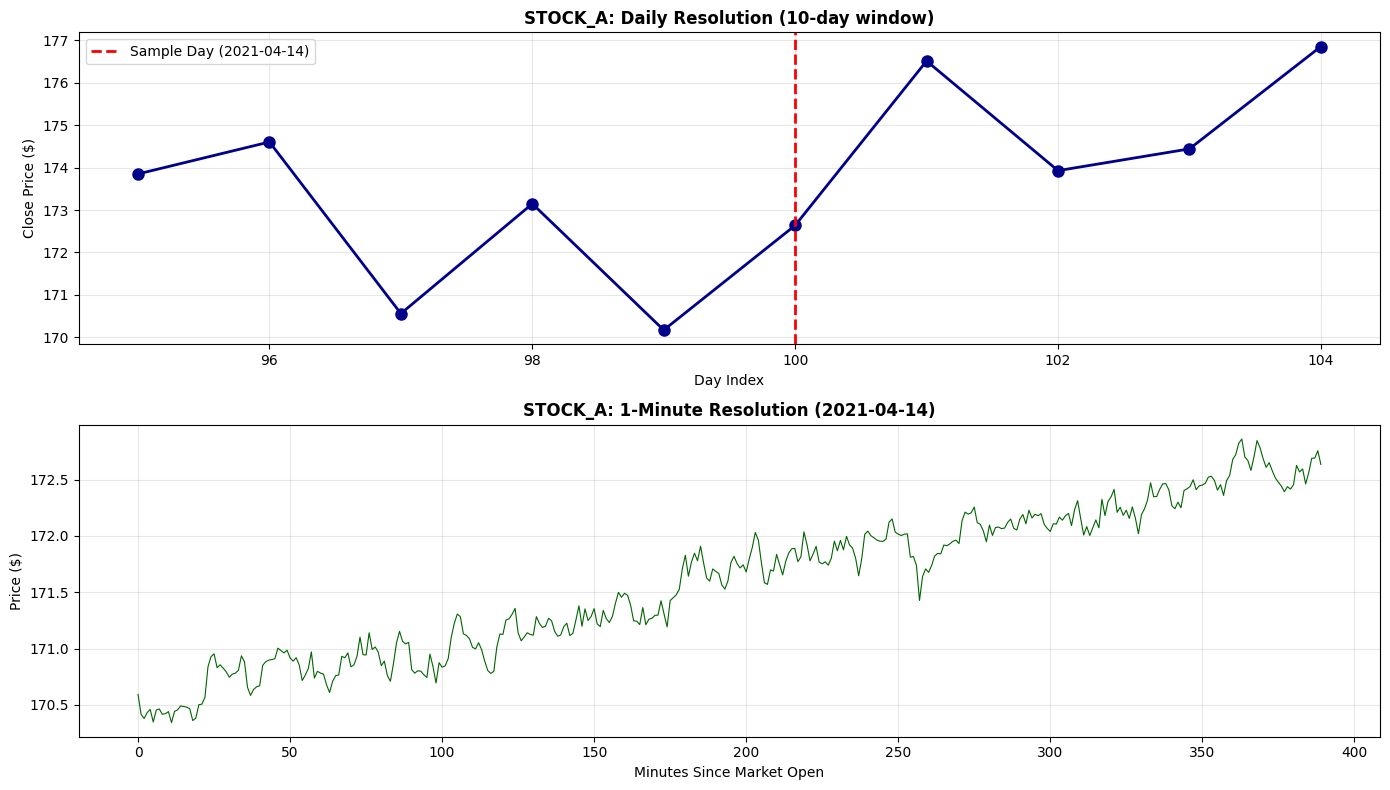


**Resolution Dimension:**
  Daily: 10 observations capture multi-day trends
  Intraday: 390 observations capture within-day dynamics
  Higher resolution → more data, more noise, more computational cost


In [ ]:

# %% [markdown]
# ## 2. Market Data as a Structured Object
#
# Now let's explore different ways to represent and access the market data
# tensor using pure Python structures. We'll also generate intraday data
# to illustrate the resolution dimension.

# %% [markdown]
# ### 2.1 Panel-Style Structure (List of Dicts)
#
# One common representation: a list where each element is a dict representing
# one observation across all attributes.

# %% [code]
def create_panel_structure(market_data):
    """
    Convert market_data to a 'long' panel format: list of dicts.
    Each dict represents (date, ticker, attributes).

    Returns:
    --------
    panel : list of dict
        Each dict has keys: 'date', 'ticker', 'close', 'volume', etc.
    """
    panel = []

    for ticker, data in market_data.items():
        for i in range(len(data['dates'])):
            obs = {
                'date': data['dates'][i],
                'ticker': ticker,
                'close': data['prices'][i],
                'return': data['returns'][i],
                'volume': data['volumes'][i],
                'open': data['ohlc'][i]['open'],
                'high': data['ohlc'][i]['high'],
                'low': data['ohlc'][i]['low']
            }
            panel.append(obs)

    return panel


panel_data = create_panel_structure(market_data)

print(f"Panel structure created: {len(panel_data)} observations")
print(f"  (= {len(assets)} assets × {n_days} days)")
print(f"\nFirst 5 observations:")
for obs in panel_data[:5]:
    print(f"  {obs}")

# %% [markdown]
# ### 2.2 Generating Intraday Data (1-Minute Bars)
#
# To illustrate the **resolution dimension**, let's generate 1 day of
# 1-minute bars for STOCK_A.

# %% [code]
def generate_intraday_bars(daily_open, daily_close, daily_high, daily_low,
                          daily_volume, n_minutes=390):
    """
    Generate synthetic intraday 1-minute bars for one trading day.

    Parameters:
    -----------
    daily_open, daily_close, daily_high, daily_low : float
        Daily OHLC values to respect
    daily_volume : int
        Total daily volume to distribute
    n_minutes : int
        Number of trading minutes (390 for US equity market: 9:30-16:00)

    Returns:
    --------
    intraday_bars : list of dict
        Each dict represents one 1-minute bar with keys:
        'minute', 'open', 'high', 'low', 'close', 'volume'
    """
    # Create a smooth intraday price path
    # Use a random walk with drift toward daily close

    bars = []
    current_price = daily_open
    cumulative_volume = 0

    for minute in range(n_minutes):
        # Fraction of day completed
        frac = minute / n_minutes

        # Target price (interpolate toward close)
        target = daily_open * (1 - frac) + daily_close * frac

        # Random walk with mean reversion to target
        drift = 0.2 * (target - current_price) / current_price
        noise = 0.0005 * np.random.randn()
        minute_return = drift + noise

        new_price = current_price * (1 + minute_return)

        # OHLC for this minute
        intraday_range = abs(new_price - current_price) * np.random.uniform(0.5, 1.5)
        high = max(current_price, new_price) + intraday_range * 0.3
        low = min(current_price, new_price) - intraday_range * 0.3

        # Volume: U-shaped intraday pattern
        # Higher at open and close
        u_shape_factor = 1.5 - np.cos(2 * np.pi * frac)  # U-shaped
        base_vol = daily_volume / n_minutes
        vol = int(base_vol * u_shape_factor * (1 + 0.3 * np.random.randn()))
        vol = max(vol, 100)

        bars.append({
            'minute': minute,
            'open': current_price,
            'high': high,
            'low': low,
            'close': new_price,
            'volume': vol
        })

        current_price = new_price
        cumulative_volume += vol

    # Scale volumes to match daily total
    volume_scale = daily_volume / cumulative_volume
    for bar in bars:
        bar['volume'] = int(bar['volume'] * volume_scale)

    return bars


# Generate intraday data for one day of STOCK_A
sample_day_idx = 100
sample_day_data = market_data['STOCK_A']

intraday_data = generate_intraday_bars(
    daily_open=sample_day_data['ohlc'][sample_day_idx]['open'],
    daily_close=sample_day_data['ohlc'][sample_day_idx]['close'],
    daily_high=sample_day_data['ohlc'][sample_day_idx]['high'],
    daily_low=sample_day_data['ohlc'][sample_day_idx]['low'],
    daily_volume=sample_day_data['volumes'][sample_day_idx],
    n_minutes=390
)

print(f"Generated {len(intraday_data)} 1-minute bars for STOCK_A")
print(f"Date: {sample_day_data['dates'][sample_day_idx]}")
print(f"\nFirst 5 bars:")
for bar in intraday_data[:5]:
    print(f"  Minute {bar['minute']:3d}: Close={bar['close']:.2f}, Vol={bar['volume']}")

# %% [markdown]
# ### 2.3 Visualizing Resolution Layers

# %% [code]
# Plot daily vs intraday resolution
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Daily resolution (10 days around our sample day)
start_idx = max(0, sample_day_idx - 5)
end_idx = min(len(sample_day_data['prices']), sample_day_idx + 5)
daily_window = list(range(start_idx, end_idx))
daily_prices = [sample_day_data['prices'][i] for i in daily_window]

axes[0].plot(daily_window, daily_prices, linewidth=2, marker='o', markersize=8,
             color='darkblue')
axes[0].axvline(sample_day_idx, color='red', linestyle='--', linewidth=2,
                label=f'Sample Day ({sample_day_data["dates"][sample_day_idx]})')
axes[0].set_title('STOCK_A: Daily Resolution (10-day window)', fontweight='bold')
axes[0].set_xlabel('Day Index')
axes[0].set_ylabel('Close Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Intraday resolution (1-minute bars)
minutes = [bar['minute'] for bar in intraday_data]
intraday_prices = [bar['close'] for bar in intraday_data]

axes[1].plot(minutes, intraday_prices, linewidth=0.8, color='darkgreen')
axes[1].set_title(f'STOCK_A: 1-Minute Resolution ({sample_day_data["dates"][sample_day_idx]})',
                  fontweight='bold')
axes[1].set_xlabel('Minutes Since Market Open')
axes[1].set_ylabel('Price ($)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n**Resolution Dimension:**")
print(f"  Daily: {len(daily_window)} observations capture multi-day trends")
print(f"  Intraday: {len(intraday_data)} observations capture within-day dynamics")
print("  Higher resolution → more data, more noise, more computational cost")

## 5.PRICE DEFINITIONS AND RETURNS

###5.1.OVERVIEW



Returns are the fundamental building blocks of quantitative finance, yet their definition is not as simple as it first appears. This section implements multiple return definitions from scratch and explores when each matters.

**Why Return Definitions Matter**

You might think a return is just "how much the price changed," but critical choices hide in that simplicity. Do you use simple arithmetic returns or logarithmic returns? Do you measure raw returns or excess returns above a risk-free rate? Over what horizon? These choices affect portfolio optimization, risk measurement, performance attribution, and backtesting results.

**What We'll Implement**

We build pure Python functions for:

- **Simple returns**: `(P_t - P_{t-1}) / P_{t-1}` — intuitive, additive across assets
- **Log returns**: `ln(P_t / P_{t-1})` — additive across time, theoretically cleaner
- **Excess returns**: returns minus risk-free rate — what you actually earn above cash
- **Multi-period returns**: returns over horizons longer than one day — critical for strategy evaluation

Each implementation uses only lists and basic math—no libraries, no abstractions. You'll see exactly what happens to each number.

**Practical Implications**

For typical daily equity returns (under 5%), simple and log returns are nearly identical. But for high-volatility assets, longer horizons, or derivative payoffs, the differences compound and matter. We'll visualize these differences with histograms and scatter plots.

We'll also show cumulative wealth paths: how $1 invested grows over time using each return definition. This makes abstract formulas concrete—you'll see your money grow (or shrink) based on which definition you choose.

Understanding returns deeply prevents subtle bugs in backtests, risk models, and optimization. Get this foundation right, and everything else becomes easier.

###5.2.CODE AND IMPLEMENTATION

Return calculations for STOCK_A:
Simple returns (first 10 valid):
  [0.008549, -0.00155, -0.002615, -0.002306, 0.017733, 0.009656, -0.004791, 0.006118, 0.002822, -0.016009]

Log returns (first 10 valid):
  [0.008512, -0.001551, -0.002619, -0.002309, 0.017578, 0.00961, -0.004803, 0.0061, 0.002818, -0.016139]


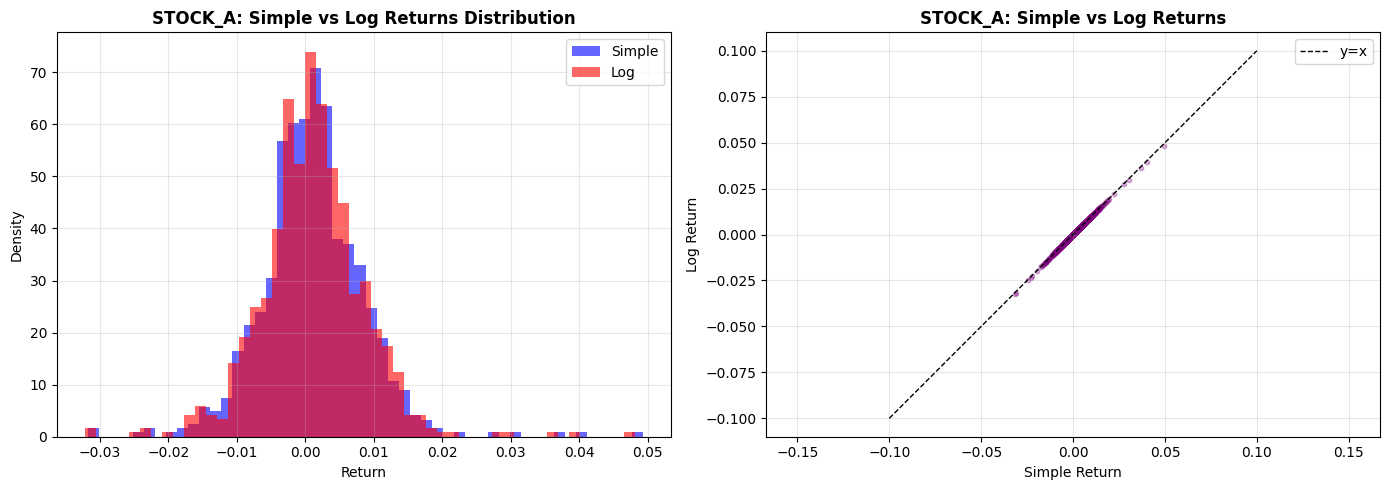


Difference (Simple - Log):
  Mean: 0.00002878
  Max absolute: 0.00117666


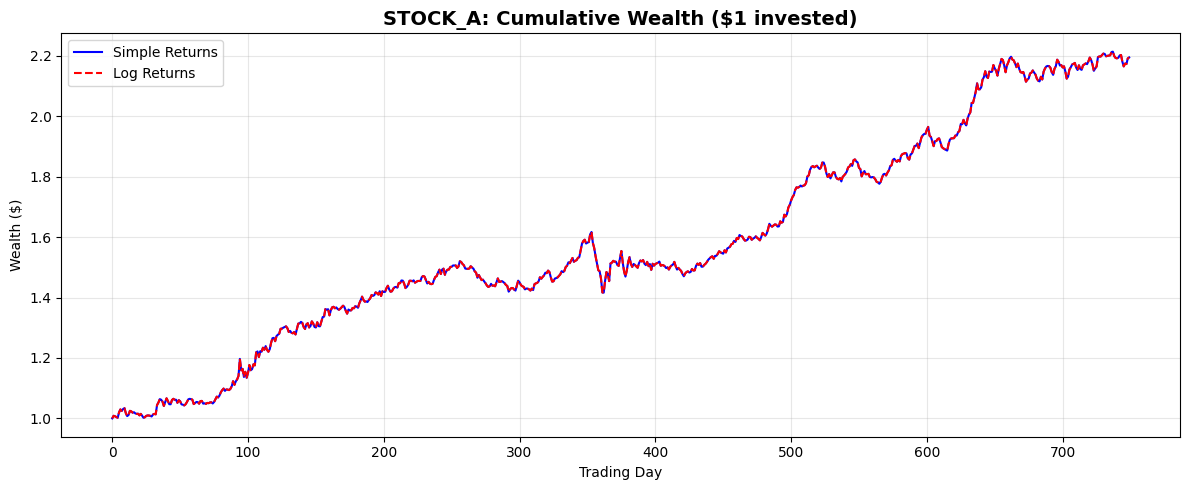

Final wealth (simple): $2.20
Final wealth (log):    $2.20
Nearly identical for typical daily return magnitudes!

Summary Statistics:
Mean raw return:    0.001078 (annualized: 0.2718)
Mean excess return: 0.000999 (annualized: 0.2518)
Daily risk-free:    0.000079 (annualized: 0.0200)


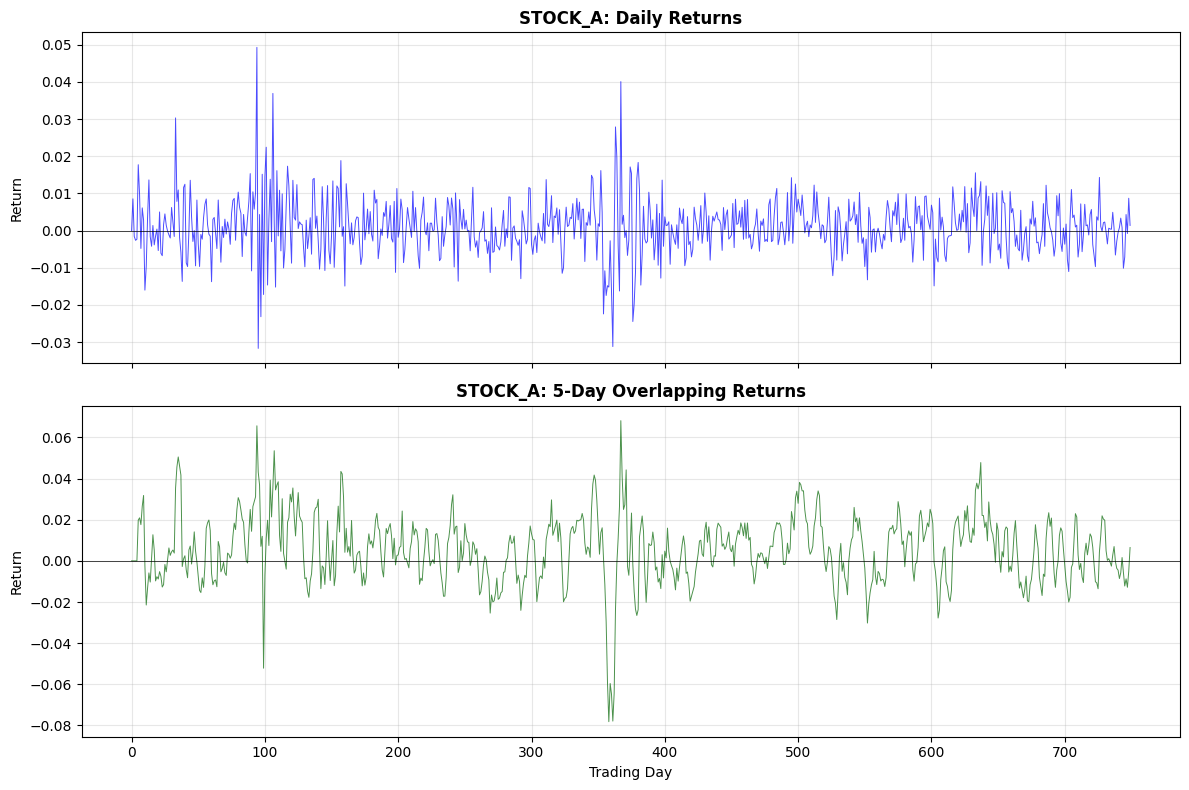


Volatility comparison:
1-day returns std:  0.007530
5-day returns std:  0.016302
Sqrt(5) scaling:    0.016838


In [ ]:

# %% [markdown]
# ## 3. Price Definitions and Returns
#
# Let's implement return calculations from first principles using pure Python
# (no pandas).

# %% [markdown]
# ### 3.1 Return Calculation Functions

# %% [code]
def simple_returns(prices):
    """
    Compute simple returns from a price list.

    Returns:
    --------
    list of float (first element is None)
    """
    returns = [None]  # First return undefined
    for i in range(1, len(prices)):
        ret = (prices[i] - prices[i-1]) / prices[i-1]
        returns.append(ret)
    return returns


def log_returns(prices):
    """
    Compute log returns from a price list.

    Returns:
    --------
    list of float (first element is None)
    """
    returns = [None]
    for i in range(1, len(prices)):
        ret = log(prices[i] / prices[i-1])
        returns.append(ret)
    return returns


def excess_returns(returns, risk_free_rate):
    """
    Subtract risk-free rate from returns.

    Parameters:
    -----------
    returns : list of float
    risk_free_rate : float (should match return frequency)

    Returns:
    --------
    list of float
    """
    return [r - risk_free_rate if r is not None else None for r in returns]


# Test with STOCK_A
stock_a_prices = market_data['STOCK_A']['prices']
stock_a_simple = simple_returns(stock_a_prices)
stock_a_log = log_returns(stock_a_prices)

print("Return calculations for STOCK_A:")
print(f"Simple returns (first 10 valid):")
valid_simple = [r for r in stock_a_simple if r is not None]
print(f"  {[round(r, 6) for r in valid_simple[:10]]}")

print(f"\nLog returns (first 10 valid):")
valid_log = [r for r in stock_a_log if r is not None]
print(f"  {[round(r, 6) for r in valid_log[:10]]}")

# %% [markdown]
# ### 3.2 Comparing Simple vs Log Returns

# %% [code]
# Compare distributions
# Remove Nones for plotting
simple_clean = [r for r in stock_a_simple if r is not None]
log_clean = [r for r in stock_a_log if r is not None]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograms
axes[0].hist(simple_clean, bins=50, alpha=0.6, label='Simple', color='blue', density=True)
axes[0].hist(log_clean, bins=50, alpha=0.6, label='Log', color='red', density=True)
axes[0].set_title('STOCK_A: Simple vs Log Returns Distribution', fontweight='bold')
axes[0].set_xlabel('Return')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter plot
axes[1].scatter(simple_clean, log_clean, alpha=0.3, s=10, color='purple')
axes[1].plot([-0.1, 0.1], [-0.1, 0.1], 'k--', linewidth=1, label='y=x')
axes[1].set_title('STOCK_A: Simple vs Log Returns', fontweight='bold')
axes[1].set_xlabel('Simple Return')
axes[1].set_ylabel('Log Return')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axis('equal')

plt.tight_layout()
plt.show()

# Compute difference
differences = [s - l for s, l in zip(simple_clean, log_clean)]
mean_diff = sum(differences) / len(differences)
max_abs_diff = max(abs(d) for d in differences)

print(f"\nDifference (Simple - Log):")
print(f"  Mean: {mean_diff:.8f}")
print(f"  Max absolute: {max_abs_diff:.8f}")

# %% [markdown]
# ### 3.3 Cumulative Wealth Paths

# %% [code]
def cumulative_wealth_from_simple(returns, initial_wealth=1.0):
    """
    Compute cumulative wealth from simple returns.
    Wealth[t] = Wealth[t-1] * (1 + return[t])
    """
    wealth = [initial_wealth]
    for ret in returns[1:]:  # Skip first None
        wealth.append(wealth[-1] * (1 + ret))
    return wealth


def cumulative_wealth_from_log(returns, initial_wealth=1.0):
    """
    Compute cumulative wealth from log returns.
    Wealth[t] = initial_wealth * exp(sum of log returns up to t)
    """
    wealth = [initial_wealth]
    cumsum = 0.0
    for ret in returns[1:]:
        cumsum += ret
        wealth.append(initial_wealth * exp(cumsum))
    return wealth


wealth_simple = cumulative_wealth_from_simple(stock_a_simple)
wealth_log = cumulative_wealth_from_log(stock_a_log)

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
x = list(range(len(wealth_simple)))
ax.plot(x, wealth_simple, linewidth=1.5, label='Simple Returns', color='blue')
ax.plot(x, wealth_log, linewidth=1.5, label='Log Returns', linestyle='--', color='red')
ax.set_title('STOCK_A: Cumulative Wealth ($1 invested)', fontsize=14, fontweight='bold')
ax.set_xlabel('Trading Day')
ax.set_ylabel('Wealth ($)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final wealth (simple): ${wealth_simple[-1]:.2f}")
print(f"Final wealth (log):    ${wealth_log[-1]:.2f}")
print("Nearly identical for typical daily return magnitudes!")

# %% [markdown]
# ### 3.4 Excess Returns

# %% [code]
# Assume 2% annual risk-free rate
annual_rf = 0.02
daily_rf = annual_rf / 252

stock_a_excess = excess_returns(stock_a_simple, daily_rf)

# Summary stats (manual calculation)
def mean(values):
    """Compute mean, skipping None values."""
    clean = [v for v in values if v is not None]
    return sum(clean) / len(clean) if clean else 0.0

def std(values):
    """Compute standard deviation, skipping None values."""
    clean = [v for v in values if v is not None]
    if len(clean) < 2:
        return 0.0
    mu = mean(clean)
    variance = sum((x - mu) ** 2 for x in clean) / (len(clean) - 1)
    return sqrt(variance)

mean_simple = mean(stock_a_simple)
mean_excess = mean(stock_a_excess)

print(f"\nSummary Statistics:")
print(f"Mean raw return:    {mean_simple:.6f} (annualized: {mean_simple*252:.4f})")
print(f"Mean excess return: {mean_excess:.6f} (annualized: {mean_excess*252:.4f})")
print(f"Daily risk-free:    {daily_rf:.6f} (annualized: {annual_rf:.4f})")

# %% [markdown]
# ### 3.5 Multi-Horizon Returns

# %% [code]
def multi_period_returns(prices, horizon):
    """
    Compute overlapping multi-period returns.

    Parameters:
    -----------
    prices : list of float
    horizon : int (e.g., 5 for 5-day returns)

    Returns:
    --------
    list of float (first 'horizon' elements are None)
    """
    returns = []
    for i in range(len(prices)):
        if i < horizon:
            returns.append(None)
        else:
            ret = (prices[i] - prices[i-horizon]) / prices[i-horizon]
            returns.append(ret)
    return returns


stock_a_5day = multi_period_returns(stock_a_prices, horizon=5)

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Daily returns
simple_for_plot = [r if r is not None else 0 for r in stock_a_simple]
axes[0].plot(simple_for_plot, linewidth=0.7, color='blue', alpha=0.7)
axes[0].axhline(0, color='black', linewidth=0.5)
axes[0].set_title('STOCK_A: Daily Returns', fontweight='bold')
axes[0].set_ylabel('Return')
axes[0].grid(True, alpha=0.3)

# 5-day returns
fiveday_for_plot = [r if r is not None else 0 for r in stock_a_5day]
axes[1].plot(fiveday_for_plot, linewidth=0.7, color='darkgreen', alpha=0.7)
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].set_title('STOCK_A: 5-Day Overlapping Returns', fontweight='bold')
axes[1].set_ylabel('Return')
axes[1].set_xlabel('Trading Day')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

vol_1day = std(stock_a_simple)
vol_5day = std(stock_a_5day)
sqrt5_scaling = vol_1day * sqrt(5)

print(f"\nVolatility comparison:")
print(f"1-day returns std:  {vol_1day:.6f}")
print(f"5-day returns std:  {vol_5day:.6f}")
print(f"Sqrt(5) scaling:    {sqrt5_scaling:.6f}")


## 6.VOLUME AND MICROSTRUCTURE

###6.1.OVERVIEW


Volume is not just a side statistic—it's a critical dimension of market data that reveals how information flows through markets and how liquidity evolves over time.

**Why Volume Matters**

Every trade has two sides: a buyer and a seller meeting at a price. Volume measures the intensity of this activity. High volume indicates strong information flow, divergent opinions, or both. Low volume suggests uncertainty, disinterest, or illiquidity. Understanding volume patterns helps you assess execution risk, detect regime changes, and improve timing.

**The Volume-Volatility Relationship**

One of the most robust empirical regularities in finance: days with high absolute returns tend to have high volume. This isn't coincidental—both are driven by information arrival. When news hits, traders rush to adjust positions, creating simultaneous price movement and trading activity. We'll generate synthetic volume that respects this correlation and verify it empirically.

**Intraday Volume Patterns: The U-Shaped Curve**

Trading volume isn't uniform throughout the day. It concentrates at the open (overnight information release, order imbalances from passive flows) and close (portfolio rebalancing, index tracking, position squaring). Mid-day tends to be quieter. This creates the famous U-shaped intraday volume profile, which we'll generate and visualize using 1-minute bars.

**Dollar Volume as a Liquidity Proxy**

Raw share volume can mislead—1 million shares of a $5 stock represents less economic activity than 100,000 shares of a $500 stock. Dollar volume (price × shares) provides a better liquidity measure. We'll compute this for our synthetic assets and show how it relates to price movements.

This section connects abstract microstructure theory to concrete, observable patterns you can measure and exploit in trading strategies.

###6.2.CODE AND IMPLEMENTATION

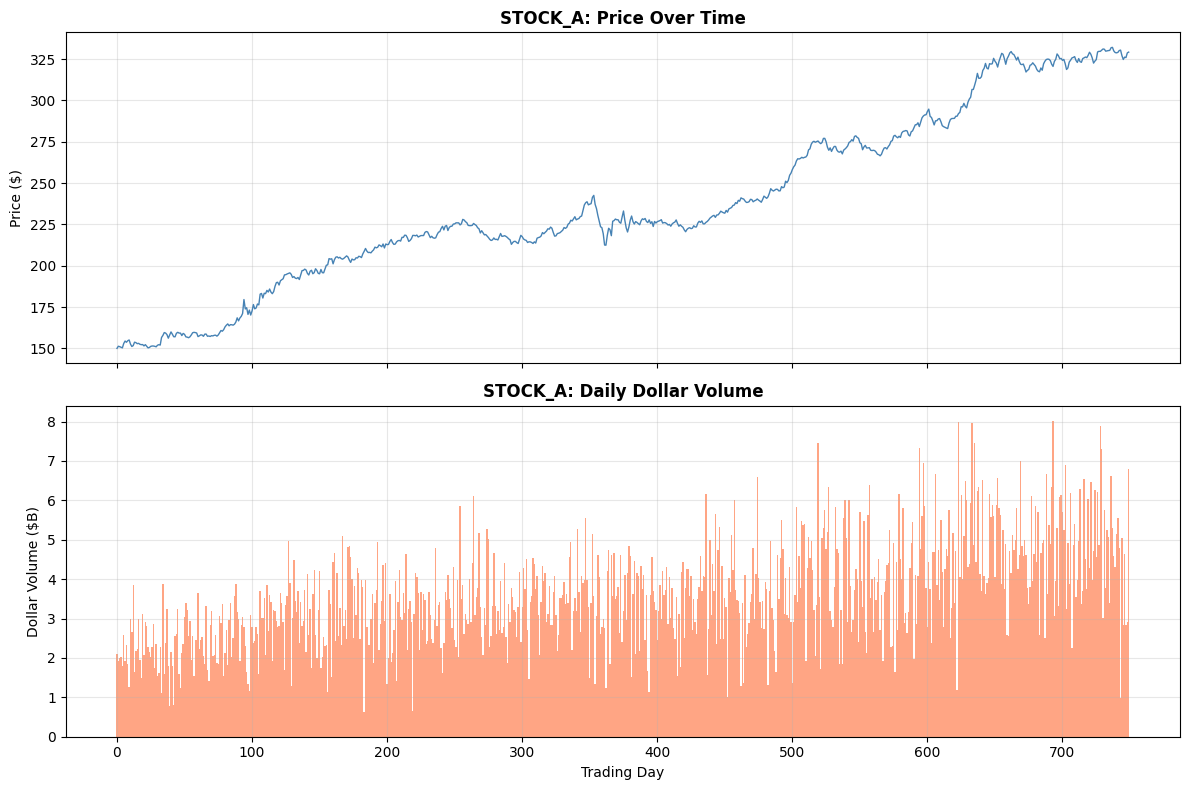

Mean daily dollar volume: $3.59B


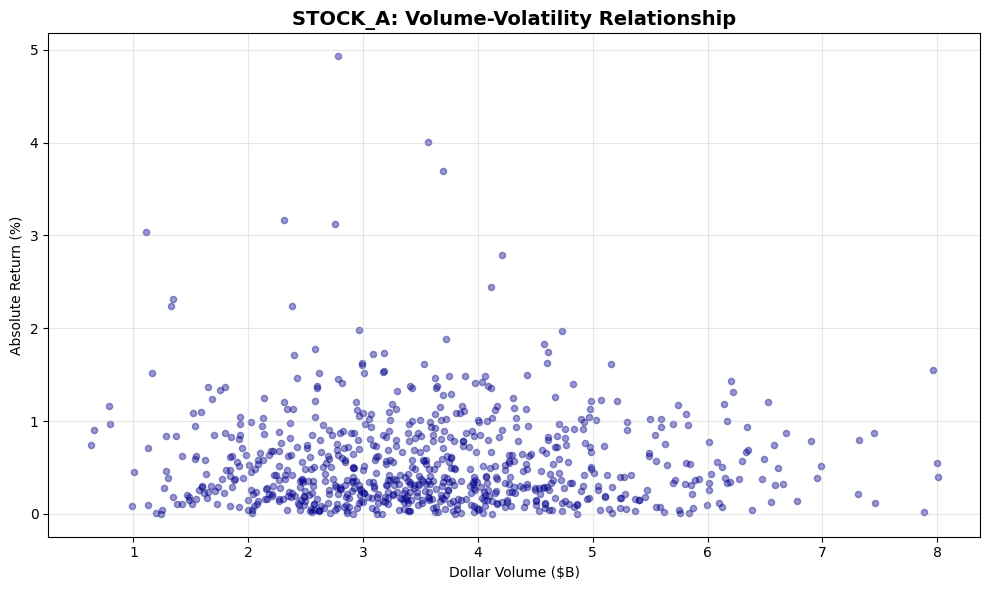

Correlation (absolute return vs dollar volume): -0.030


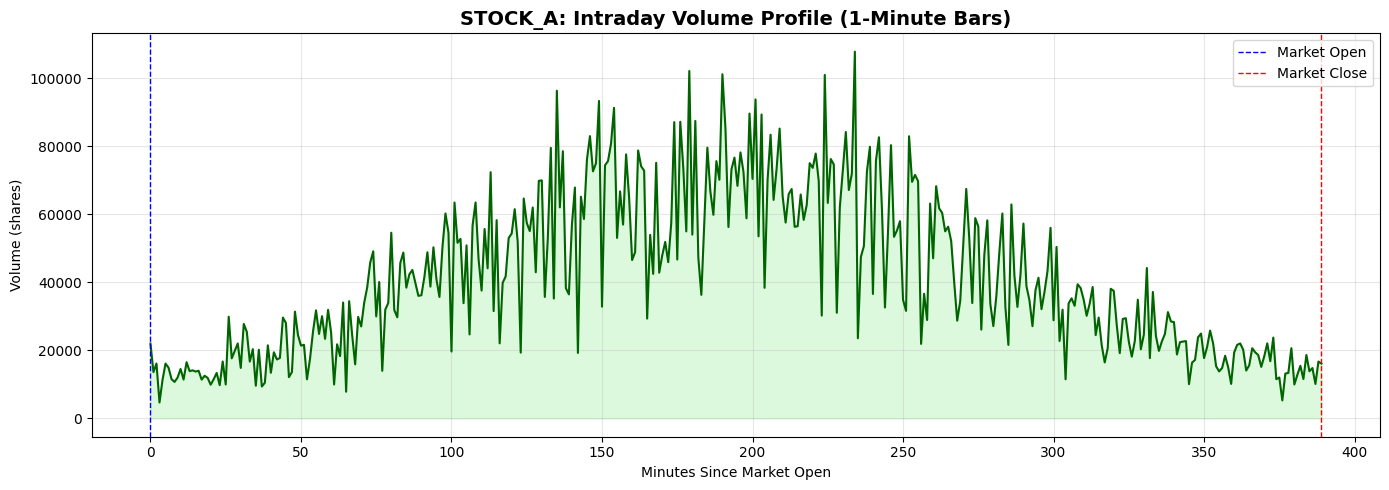


**Intraday Volume Pattern (U-Shaped):**
- High volume at market open (overnight information release)
- Lower volume mid-day
- Increasing volume toward close (position squaring, index rebalancing)
- This is a robust microstructure stylized fact


In [ ]:

# %% [markdown]
# ## 4. Volume, Liquidity, and Basic Microstructure Effects
#
# Volume is a key dimension of market data. Let's explore volume patterns
# and the volume-volatility relationship using our synthetic data.

# %% [markdown]
# ### 4.1 Daily Volume and Dollar Volume

# %% [code]
# Compute dollar volume for STOCK_A
stock_a_volumes = market_data['STOCK_A']['volumes']
stock_a_dollar_volume = [p * v for p, v in zip(stock_a_prices, stock_a_volumes)]

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axes[0].plot(stock_a_prices, linewidth=1, color='steelblue')
axes[0].set_title('STOCK_A: Price Over Time', fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].grid(True, alpha=0.3)

# Dollar volume in billions
dollar_vol_billions = [dv / 1e9 for dv in stock_a_dollar_volume]
axes[1].bar(range(len(dollar_vol_billions)), dollar_vol_billions, width=1, color='coral', alpha=0.7)
axes[1].set_title('STOCK_A: Daily Dollar Volume', fontweight='bold')
axes[1].set_ylabel('Dollar Volume ($B)')
axes[1].set_xlabel('Trading Day')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

mean_dv = mean(stock_a_dollar_volume)
print(f"Mean daily dollar volume: ${mean_dv/1e9:.2f}B")

# %% [markdown]
# ### 4.2 Volume-Volatility Relationship

# %% [code]
# Compute absolute returns
abs_returns = [abs(r) if r is not None else 0 for r in stock_a_simple]

# Scatter plot (skip first None)
abs_ret_clean = abs_returns[1:]
dollar_vol_clean = stock_a_dollar_volume[1:]

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter([dv/1e9 for dv in dollar_vol_clean], [ar*100 for ar in abs_ret_clean],
           alpha=0.4, s=20, color='darkblue')
ax.set_xlabel('Dollar Volume ($B)')
ax.set_ylabel('Absolute Return (%)')
ax.set_title('STOCK_A: Volume-Volatility Relationship', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Compute correlation manually
def correlation(x, y):
    """Compute Pearson correlation coefficient."""
    n = len(x)
    if n < 2:
        return 0.0

    mean_x = sum(x) / n
    mean_y = sum(y) / n

    cov = sum((xi - mean_x) * (yi - mean_y) for xi, yi in zip(x, y)) / (n - 1)
    std_x = sqrt(sum((xi - mean_x) ** 2 for xi in x) / (n - 1))
    std_y = sqrt(sum((yi - mean_y) ** 2 for yi in y) / (n - 1))

    return cov / (std_x * std_y) if std_x > 0 and std_y > 0 else 0.0

corr = correlation(abs_ret_clean, dollar_vol_clean)
print(f"Correlation (absolute return vs dollar volume): {corr:.3f}")

# %% [markdown]
# ### 4.3 Intraday Volume Profile (U-Shaped Curve)

# %% [code]
# Extract intraday volumes from our generated 1-minute data
intraday_volumes = [bar['volume'] for bar in intraday_data]
minutes = list(range(len(intraday_volumes)))

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(minutes, intraday_volumes, linewidth=1.5, color='darkgreen')
ax.fill_between(minutes, intraday_volumes, alpha=0.3, color='lightgreen')
ax.set_title('STOCK_A: Intraday Volume Profile (1-Minute Bars)', fontsize=14, fontweight='bold')
ax.set_xlabel('Minutes Since Market Open')
ax.set_ylabel('Volume (shares)')
ax.grid(True, alpha=0.3)

# Mark open and close
ax.axvline(0, color='blue', linestyle='--', linewidth=1, label='Market Open')
ax.axvline(len(minutes)-1, color='red', linestyle='--', linewidth=1, label='Market Close')
ax.legend()

plt.tight_layout()
plt.show()

print("\n**Intraday Volume Pattern (U-Shaped):**")
print("- High volume at market open (overnight information release)")
print("- Lower volume mid-day")
print("- Increasing volume toward close (position squaring, index rebalancing)")
print("- This is a robust microstructure stylized fact")

##7.STYLIZED FACTS

###7.1.OVERVIEW



Financial returns exhibit universal statistical properties that appear consistently across assets, markets, and time periods. These "stylised facts" are empirical regularities that any realistic model must capture.

**Fat Tails: The Failure of Normality**

If returns were normally distributed, extreme events (5+ standard deviation moves) would be vanishingly rare. In reality, they happen far more often. We call this "fat tails" or "heavy tails"—the probability mass in the distribution's extremes exceeds what a Gaussian predicts. We'll measure this using excess kurtosis (fourth moment) and visual tools like Q-Q plots. Our synthetic data, generated with volatility clustering and jumps, naturally exhibits fat tails.

**Volatility Clustering: Persistence in Turbulence**

Mandelbrot observed in the 1960s: "Large changes tend to be followed by large changes, of either sign, and small changes tend to be followed by small changes." This is volatility clustering. Calm periods persist, and turbulent periods persist. We'll demonstrate this by computing rolling volatility and showing autocorrelation in squared returns (even though returns themselves show little autocorrelation). This property motivates GARCH models and regime-switching frameworks.

**Cross-Sectional Dependence: Assets Move Together**

Assets don't evolve independently. Equities correlate strongly with each other, especially during market stress. Diversification benefits are limited within asset classes. We'll compute correlation matrices across our four synthetic assets and show how STOCK_A, STOCK_B, and INDEX_ETF cluster together while FX_PROXY remains more independent. We'll also demonstrate time-varying correlations using rolling windows.

These stylised facts aren't academic curiosities—they're fundamental properties that determine risk, hedging effectiveness, and strategy performance. Ignoring them leads to catastrophic model failures.

###7.2.CODE AND IMPLEMENTATION

Distribution Analysis: STOCK_A Daily Returns
Mean:                0.001078
Std Dev:             0.007530
Skewness:            0.4511
Excess Kurtosis:     4.6179
  (Normal distribution has excess kurtosis = 0)


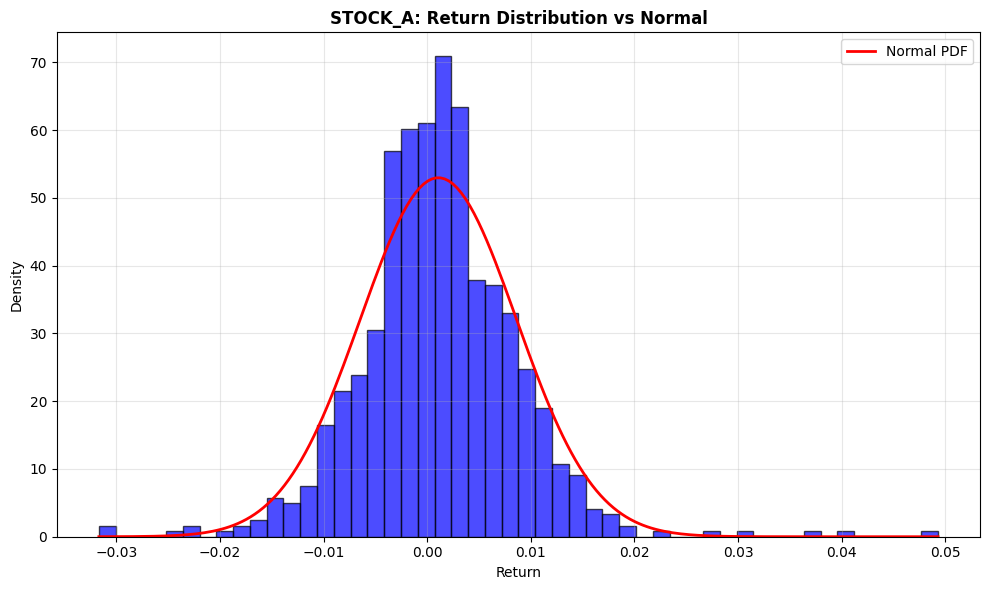


**Fat Tails:**
Positive excess kurtosis (4.62) indicates fat tails
Extreme events occur more frequently than normal distribution predicts


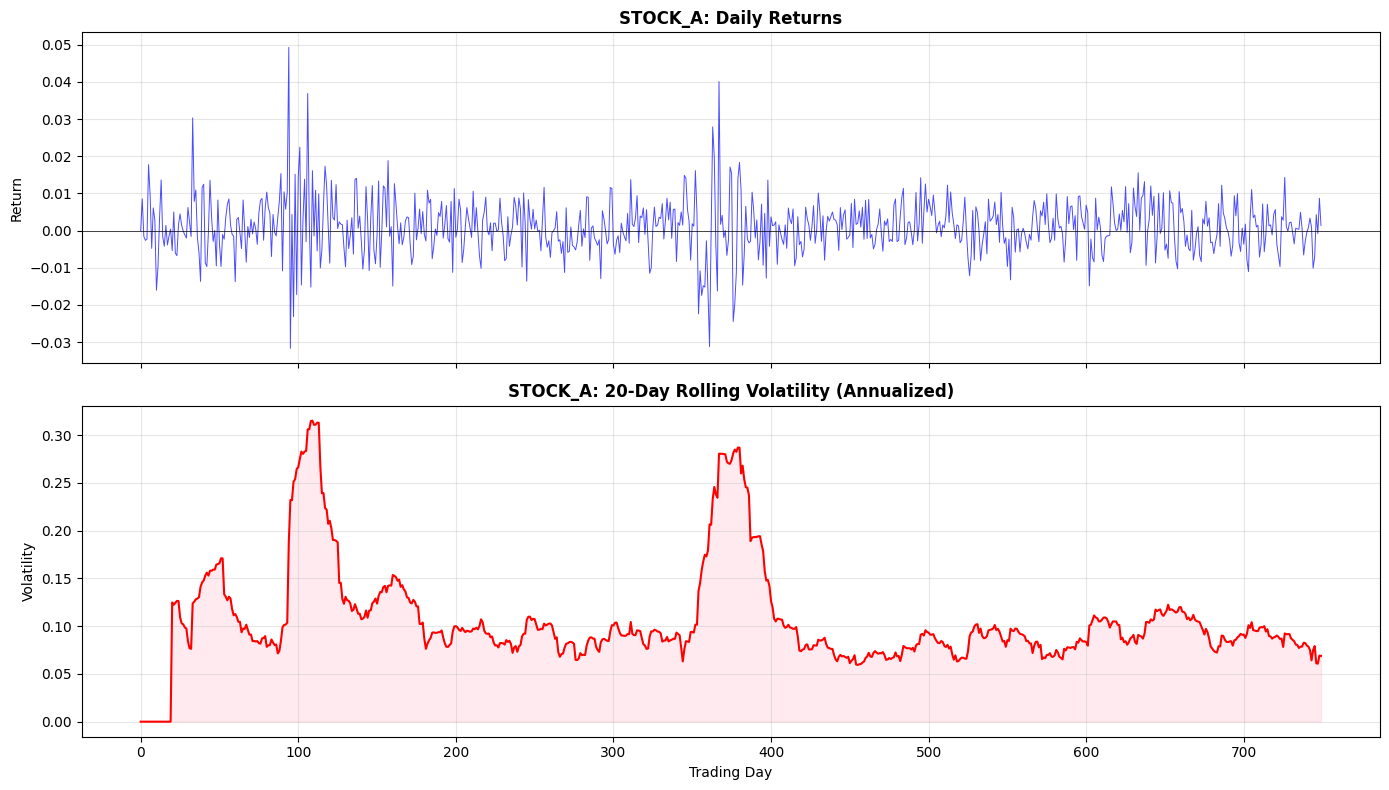


**Volatility Clustering:**
Notice how high-volatility periods (red spikes) correspond to clusters of large returns
Volatility is persistent: high vol today → likely high vol tomorrow


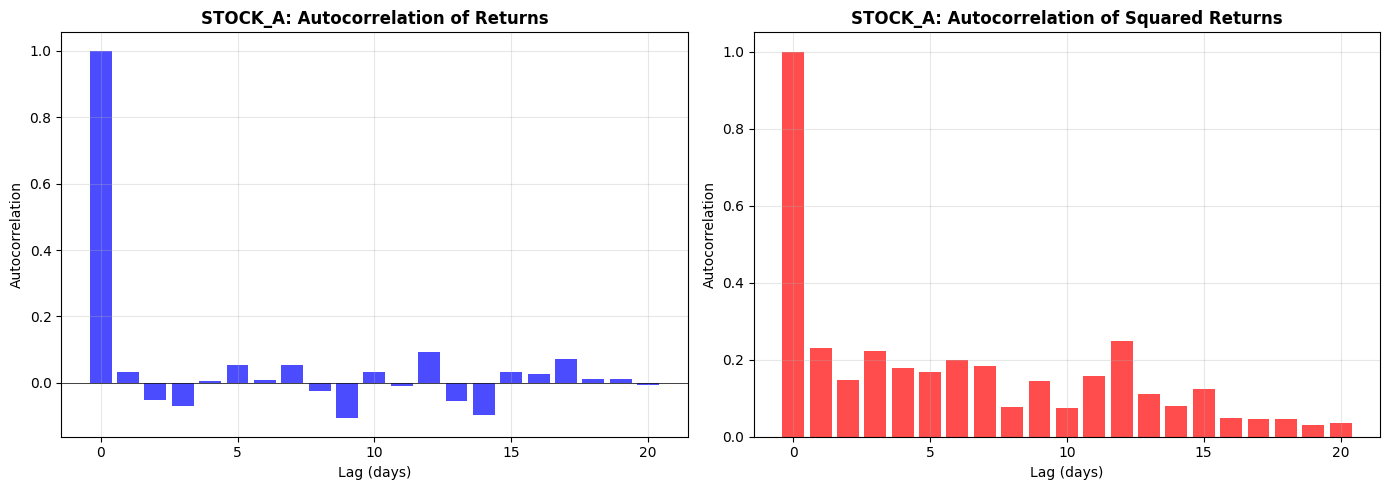


**Autocorrelation Analysis:**
- Returns show little autocorrelation (efficient markets)
- Squared returns show strong positive autocorrelation
- This is the signature of volatility clustering (GARCH effect)
Return matrix: 750 rows × 4 columns

Correlation Matrix:
                 STOCK_A     STOCK_B   INDEX_ETF    FX_PROXY
STOCK_A            1.000       0.023       0.026       0.046
STOCK_B            0.023       1.000       0.030       0.029
INDEX_ETF          0.026       0.030       1.000      -0.012
FX_PROXY           0.046       0.029      -0.012       1.000


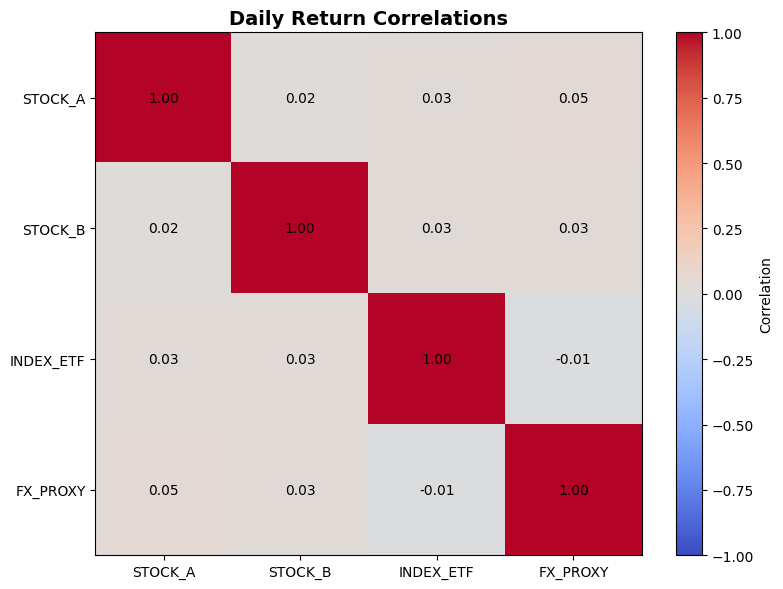


**Cross-Asset Correlations:**
- STOCK_A, STOCK_B, INDEX_ETF are highly correlated (all equities)
- FX_PROXY has lower correlation with equities
- This correlation structure limits diversification within equities
- Factor models capture these common movements


In [ ]:

# %% [markdown]
# ## 5. Stylised Facts: Distributions, Volatility Clustering, Cross-Section
#
# Financial returns exhibit several universal stylised facts. Let's verify
# them in our synthetic data (which was designed to exhibit these properties).

# %% [markdown]
# ### 5.1 Distributional Features: Fat Tails

# %% [code]
# Analyze STOCK_A returns
returns_clean = [r for r in stock_a_simple if r is not None]

# Compute moments manually
def skewness(values):
    """Compute sample skewness."""
    n = len(values)
    if n < 3:
        return 0.0
    mu = sum(values) / n
    m2 = sum((x - mu) ** 2 for x in values) / n
    m3 = sum((x - mu) ** 3 for x in values) / n
    return m3 / (m2 ** 1.5) if m2 > 0 else 0.0

def excess_kurtosis(values):
    """Compute sample excess kurtosis (kurtosis - 3)."""
    n = len(values)
    if n < 4:
        return 0.0
    mu = sum(values) / n
    m2 = sum((x - mu) ** 2 for x in values) / n
    m4 = sum((x - mu) ** 4 for x in values) / n
    return (m4 / (m2 ** 2)) - 3.0 if m2 > 0 else 0.0

mean_ret = mean(returns_clean)
std_ret = std(returns_clean)
skew_ret = skewness(returns_clean)
kurt_ret = excess_kurtosis(returns_clean)

print("Distribution Analysis: STOCK_A Daily Returns")
print("=" * 60)
print(f"Mean:                {mean_ret:.6f}")
print(f"Std Dev:             {std_ret:.6f}")
print(f"Skewness:            {skew_ret:.4f}")
print(f"Excess Kurtosis:     {kurt_ret:.4f}")
print(f"  (Normal distribution has excess kurtosis = 0)")

# %% [code]
# Plot histogram with normal overlay
fig, ax = plt.subplots(figsize=(10, 6))

# Histogram
n_bins = 50
counts, bins = np.histogram(returns_clean, bins=n_bins, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2
ax.bar(bin_centers, counts, width=bins[1]-bins[0], alpha=0.7, color='blue', edgecolor='black')

# Overlay normal PDF
x_range = np.linspace(min(returns_clean), max(returns_clean), 200)
from math import pi
normal_pdf = [exp(-0.5 * ((x - mean_ret) / std_ret) ** 2) / (std_ret * sqrt(2 * pi))
              for x in x_range]
ax.plot(x_range, normal_pdf, 'r-', linewidth=2, label='Normal PDF')

ax.set_title('STOCK_A: Return Distribution vs Normal', fontweight='bold')
ax.set_xlabel('Return')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n**Fat Tails:**")
print(f"Positive excess kurtosis ({kurt_ret:.2f}) indicates fat tails")
print(f"Extreme events occur more frequently than normal distribution predicts")

# %% [markdown]
# ### 5.2 Volatility Clustering

# %% [code]
def rolling_volatility(returns, window=20, annualization=252):
    """
    Compute rolling standard deviation of returns.

    Parameters:
    -----------
    returns : list of float
    window : int
    annualization : float (252 for daily to annual)

    Returns:
    --------
    list of float (first 'window' elements are None)
    """
    vol = []
    returns_clean = [r for r in returns if r is not None]

    for i in range(len(returns)):
        if i < window:
            vol.append(None)
        else:
            # Get window of returns
            window_returns = returns_clean[max(0, i-window):i]
            if len(window_returns) >= 2:
                window_std = std(window_returns)
                vol.append(window_std * sqrt(annualization))
            else:
                vol.append(None)

    return vol


rolling_vol = rolling_volatility(stock_a_simple, window=20)

# Plot returns and rolling volatility
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Returns
axes[0].plot(simple_for_plot, linewidth=0.7, color='blue', alpha=0.7)
axes[0].axhline(0, color='black', linewidth=0.5)
axes[0].set_title('STOCK_A: Daily Returns', fontweight='bold')
axes[0].set_ylabel('Return')
axes[0].grid(True, alpha=0.3)

# Rolling volatility
vol_for_plot = [v if v is not None else 0 for v in rolling_vol]
axes[1].plot(vol_for_plot, linewidth=1.5, color='red')
axes[1].fill_between(range(len(vol_for_plot)), vol_for_plot, alpha=0.3, color='pink')
axes[1].set_title('STOCK_A: 20-Day Rolling Volatility (Annualized)', fontweight='bold')
axes[1].set_ylabel('Volatility')
axes[1].set_xlabel('Trading Day')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n**Volatility Clustering:**")
print("Notice how high-volatility periods (red spikes) correspond to clusters of large returns")
print("Volatility is persistent: high vol today → likely high vol tomorrow")

# %% [code]
# Autocorrelation of squared returns
def autocorrelation(series, lag):
    """
    Compute autocorrelation at given lag.

    Parameters:
    -----------
    series : list of float
    lag : int

    Returns:
    --------
    float (autocorrelation coefficient)
    """
    clean = [s for s in series if s is not None]
    n = len(clean)

    if n <= lag:
        return 0.0

    # Compute autocorrelation
    mean_val = sum(clean) / n

    numerator = sum((clean[i] - mean_val) * (clean[i-lag] - mean_val)
                    for i in range(lag, n))
    denominator = sum((x - mean_val) ** 2 for x in clean)

    return numerator / denominator if denominator > 0 else 0.0


# Compute ACF for returns and squared returns
max_lag = 20
returns_acf = [autocorrelation(returns_clean, lag) for lag in range(max_lag + 1)]

squared_returns = [r ** 2 for r in returns_clean]
squared_acf = [autocorrelation(squared_returns, lag) for lag in range(max_lag + 1)]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(max_lag + 1), returns_acf, color='blue', alpha=0.7)
axes[0].axhline(0, color='black', linewidth=0.5)
axes[0].set_title('STOCK_A: Autocorrelation of Returns', fontweight='bold')
axes[0].set_xlabel('Lag (days)')
axes[0].set_ylabel('Autocorrelation')
axes[0].grid(True, alpha=0.3)

axes[1].bar(range(max_lag + 1), squared_acf, color='red', alpha=0.7)
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].set_title('STOCK_A: Autocorrelation of Squared Returns', fontweight='bold')
axes[1].set_xlabel('Lag (days)')
axes[1].set_ylabel('Autocorrelation')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n**Autocorrelation Analysis:**")
print("- Returns show little autocorrelation (efficient markets)")
print("- Squared returns show strong positive autocorrelation")
print("- This is the signature of volatility clustering (GARCH effect)")

# %% [markdown]
# ### 5.3 Cross-Sectional Dependence

# %% [code]
# Build a return matrix: each row is one date, each column is one asset
# First, align all return series (they should already be aligned)

tickers = list(market_data.keys())
n_obs = len(market_data[tickers[0]]['returns'])

# Create return matrix as list of lists
return_matrix = []
for i in range(n_obs):
    row = []
    for ticker in tickers:
        ret = market_data[ticker]['returns'][i]
        row.append(ret if ret is not None else 0.0)
    return_matrix.append(row)

print(f"Return matrix: {len(return_matrix)} rows × {len(tickers)} columns")

# %% [code]
# Compute correlation matrix manually
def correlation_matrix(data_matrix, column_names):
    """
    Compute correlation matrix from data matrix.

    Parameters:
    -----------
    data_matrix : list of lists (rows = observations, columns = variables)
    column_names : list of str

    Returns:
    --------
    corr_matrix : dict of dict
        corr_matrix[ticker1][ticker2] = correlation
    """
    n_cols = len(column_names)

    # Extract columns
    columns = []
    for col_idx in range(n_cols):
        column = [row[col_idx] for row in data_matrix]
        columns.append(column)

    # Compute correlations
    corr_matrix = {}
    for i, name_i in enumerate(column_names):
        corr_matrix[name_i] = {}
        for j, name_j in enumerate(column_names):
            corr_matrix[name_i][name_j] = correlation(columns[i], columns[j])

    return corr_matrix


corr_matrix = correlation_matrix(return_matrix[1:], tickers)  # Skip first row with None

print("\nCorrelation Matrix:")
print(f"{'':12s}", end='')
for ticker in tickers:
    print(f"{ticker:>12s}", end='')
print()
for ticker_i in tickers:
    print(f"{ticker_i:12s}", end='')
    for ticker_j in tickers:
        print(f"{corr_matrix[ticker_i][ticker_j]:12.3f}", end='')
    print()

# %% [code]
# Visualize correlation matrix as heatmap
fig, ax = plt.subplots(figsize=(8, 6))

# Create correlation matrix as 2D array for visualization
corr_array = [[corr_matrix[t1][t2] for t2 in tickers] for t1 in tickers]

im = ax.imshow(corr_array, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')

# Set ticks
ax.set_xticks(range(len(tickers)))
ax.set_yticks(range(len(tickers)))
ax.set_xticklabels(tickers)
ax.set_yticklabels(tickers)

# Add text annotations
for i in range(len(tickers)):
    for j in range(len(tickers)):
        text = ax.text(j, i, f'{corr_array[i][j]:.2f}',
                       ha="center", va="center", color="black", fontsize=10)

ax.set_title('Daily Return Correlations', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, label='Correlation')
plt.tight_layout()
plt.show()

print("\n**Cross-Asset Correlations:**")
print("- STOCK_A, STOCK_B, INDEX_ETF are highly correlated (all equities)")
print("- FX_PROXY has lower correlation with equities")
print("- This correlation structure limits diversification within equities")
print("- Factor models capture these common movements")

##8.DATA QUALITY AND MISSING DATA

###8.1.OVERVIEW



Real-world market data is never perfect. Bad ticks, missing observations, stale prices, and reporting errors are inevitable. This section teaches you to identify, diagnose, and handle data quality issues systematically.

**The Cost of Dirty Data**

A single bad tick can destroy a backtest. If a stock price suddenly shows $1,000 when it should be $100, the computed return is +900%, which inflates volatility estimates, distorts correlations, triggers false signals, and produces nonsense risk metrics. Garbage in, garbage out isn't just a cliché—it's the primary reason most backtests fail in live trading.

**Injecting Synthetic Errors**

We'll intentionally corrupt our clean synthetic data with realistic problems: price spikes (10x multiplier), crashes (0.1x multiplier), and moderate anomalies. This controlled corruption lets us see exactly how errors propagate through calculations and distort statistics like mean returns, volatility, and Sharpe ratios.

**Cleaning Heuristics**

We implement simple but effective cleaning rules from scratch: z-score filtering (flag returns beyond 4 standard deviations), percentage change limits (reject moves larger than 50% in one day), and range checks (prices must be positive). Each heuristic has trade-offs—aggressive cleaning removes real jumps; conservative cleaning lets bad data through.

**Handling Missing Data**

When observations are missing, you face three choices: forward-fill (repeat last known value), interpolate (estimate intermediate values), or leave gaps (most conservative). We implement all three and show their impact on return calculations and statistics. Forward-fill creates artificial flat periods. Interpolation invents prices that never traded. Gaps complicate time series analysis but preserve truth.

Data quality isn't glamorous, but it's the foundation of everything. This section builds healthy paranoia about your data sources.

###8.2.CODE AND IMPLEMENTATION

Injecting 3 artificial outliers at indices: [200, 350, 500]


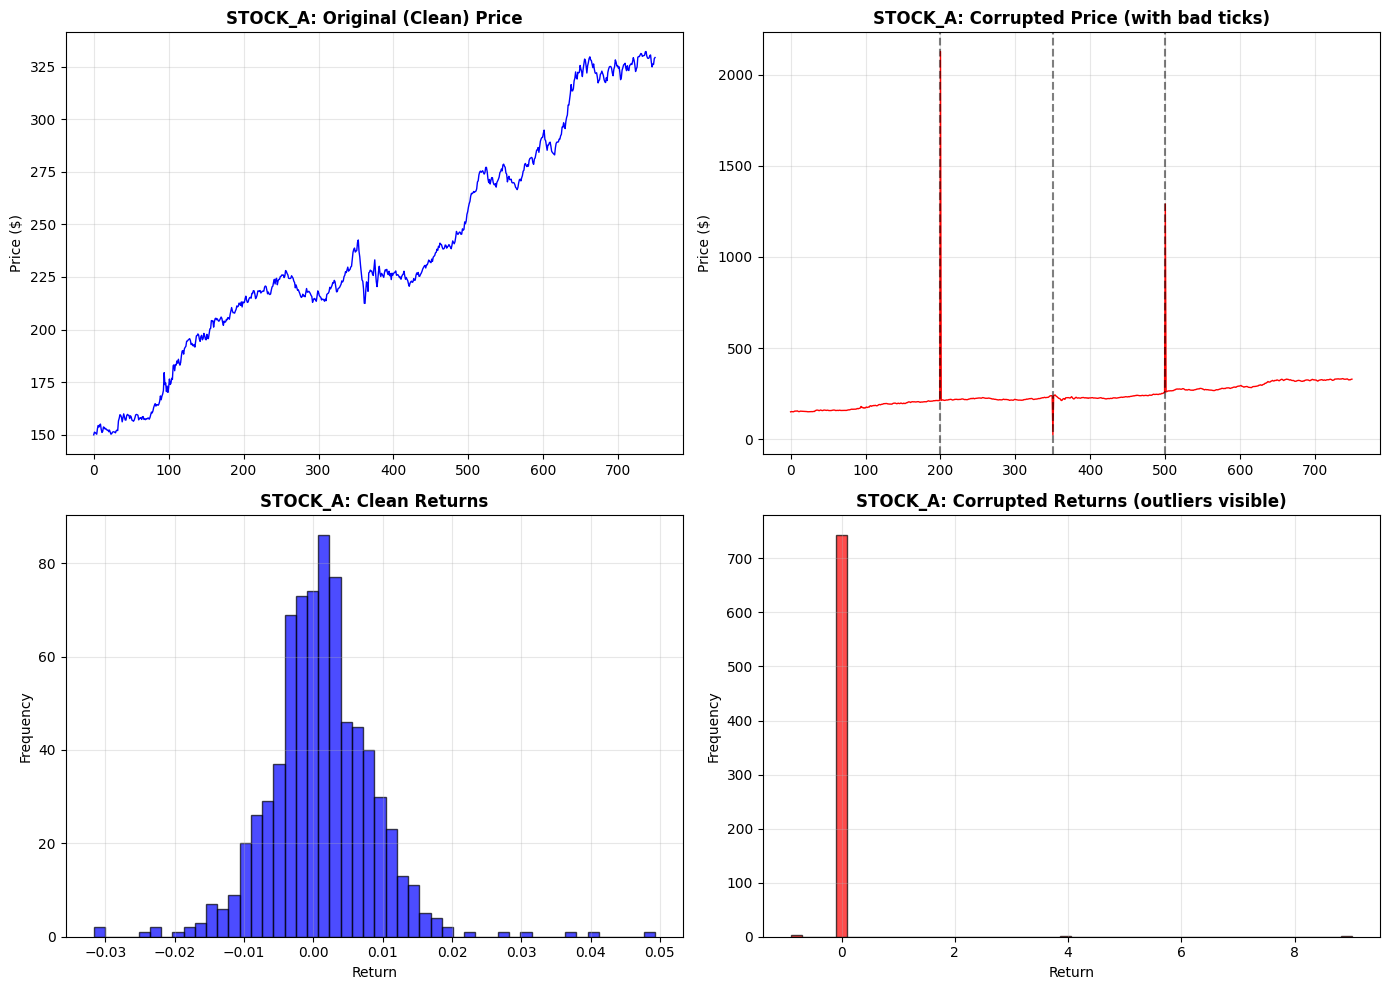


Impact on statistics:
Clean returns std:  0.007530
Dirty returns std:  0.490530
Clean returns mean: 0.001078
Dirty returns mean: 0.027008
Outliers detected: 3
Indices flagged: [200, 351, 500]


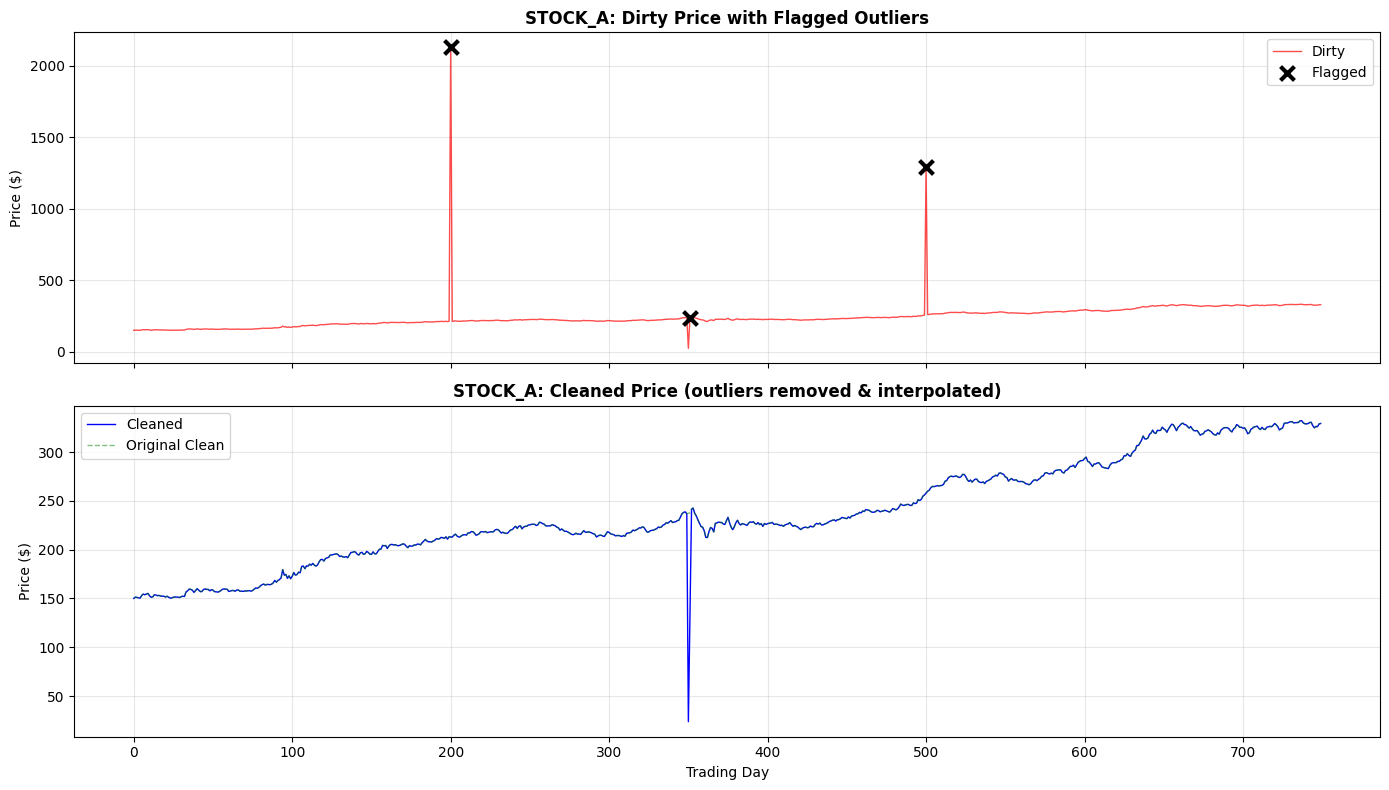

Introduced 5 missing data points at indices: [150, 250, 350, 450, 550]


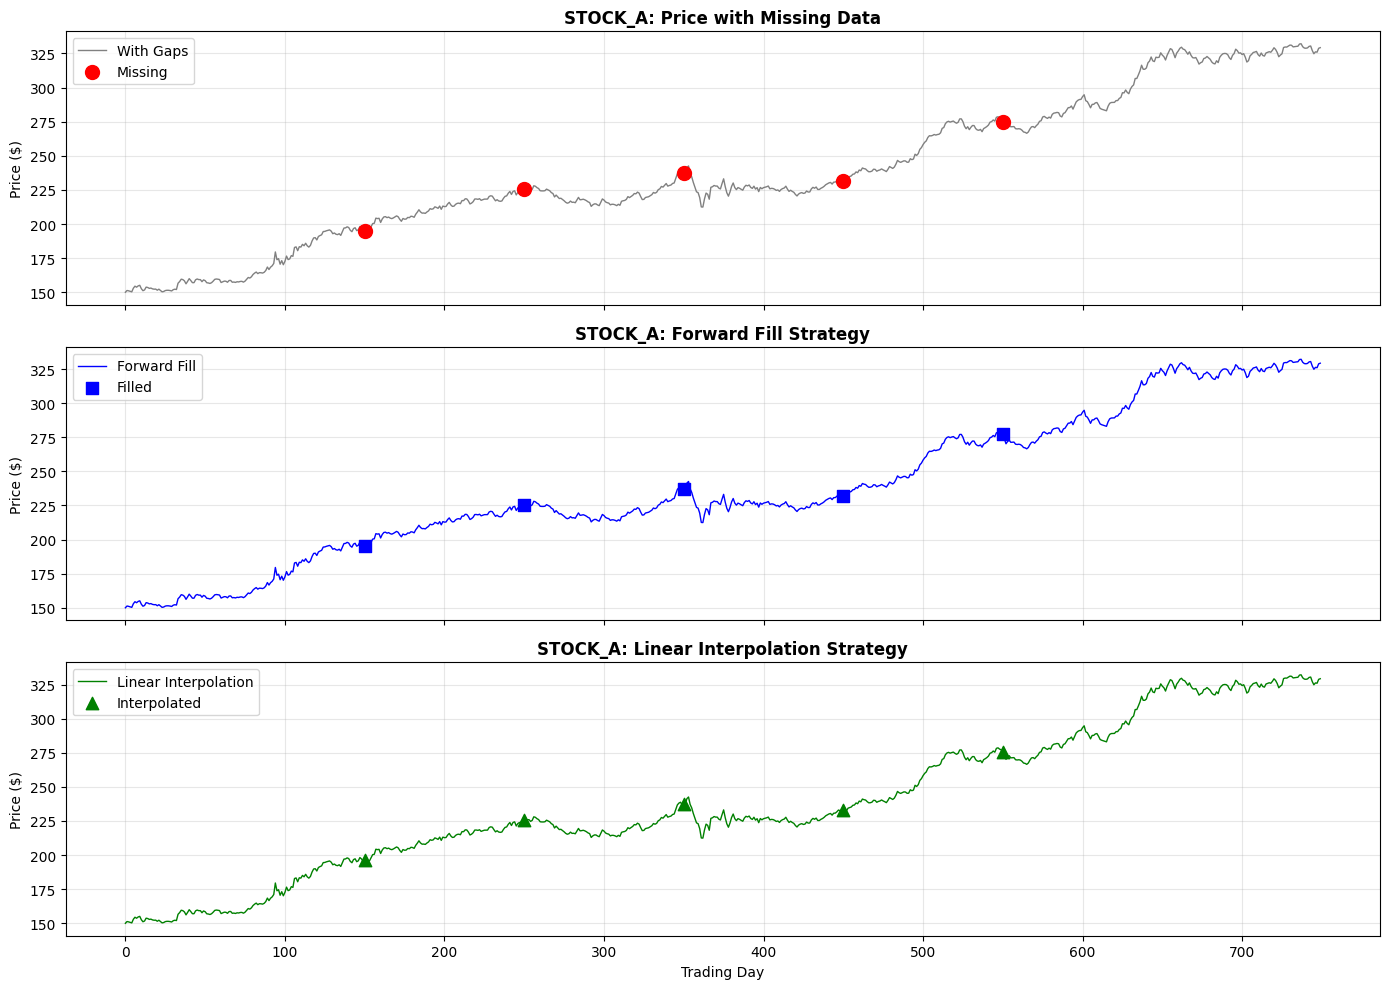


**Missing Data Strategies:**
1. Forward Fill: Preserves last known price (creates flat periods)
2. Linear Interpolation: Smooth transition (artificial prices)
3. Drop/Leave as None: Most conservative (complicates analysis)


In [ ]:

# %% [markdown]
# ## 6. Data Quality, Cleaning, and Missing Data
#
# Real-world data contains errors. Let's inject synthetic data quality issues
# and demonstrate cleaning procedures.

# %% [markdown]
# ### 6.1 Injecting Artificial Outliers

# %% [code]
# Create corrupted copy of STOCK_A prices
stock_a_dirty = stock_a_prices.copy()

# Inject outliers
np.random.seed(123)
n_outliers = 3
outlier_indices = [200, 350, 500]

print(f"Injecting {n_outliers} artificial outliers at indices: {outlier_indices}")

stock_a_dirty[outlier_indices[0]] *= 10.0  # Spike
stock_a_dirty[outlier_indices[1]] *= 0.1   # Crash
stock_a_dirty[outlier_indices[2]] *= 5.0   # Moderate spike

# Compute returns on dirty data
dirty_returns = simple_returns(stock_a_dirty)

# %% [code]
# Visualize impact
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Clean price
axes[0, 0].plot(stock_a_prices, linewidth=1, color='blue')
axes[0, 0].set_title('STOCK_A: Original (Clean) Price', fontweight='bold')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].grid(True, alpha=0.3)

# Dirty price
axes[0, 1].plot(stock_a_dirty, linewidth=1, color='red')
for idx in outlier_indices:
    axes[0, 1].axvline(idx, color='black', linestyle='--', alpha=0.5)
axes[0, 1].set_title('STOCK_A: Corrupted Price (with bad ticks)', fontweight='bold')
axes[0, 1].set_ylabel('Price ($)')
axes[0, 1].grid(True, alpha=0.3)

# Clean returns histogram
clean_hist = [r for r in stock_a_simple if r is not None]
axes[1, 0].hist(clean_hist, bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('STOCK_A: Clean Returns', fontweight='bold')
axes[1, 0].set_xlabel('Return')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# Dirty returns histogram
dirty_hist = [r for r in dirty_returns if r is not None]
axes[1, 1].hist(dirty_hist, bins=50, color='red', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('STOCK_A: Corrupted Returns (outliers visible)', fontweight='bold')
axes[1, 1].set_xlabel('Return')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nImpact on statistics:")
print(f"Clean returns std:  {std(clean_hist):.6f}")
print(f"Dirty returns std:  {std(dirty_hist):.6f}")
print(f"Clean returns mean: {mean(clean_hist):.6f}")
print(f"Dirty returns mean: {mean(dirty_hist):.6f}")

# %% [markdown]
# ### 6.2 Implementing Cleaning Heuristics

# %% [code]
def clean_price_series_zscore(prices, threshold=4.0):
    """
    Clean price series by flagging returns beyond z-score threshold.

    Returns:
    --------
    cleaned_prices : list (outliers set to None)
    flags : list of bool (True = outlier)
    """
    # Compute returns
    returns = simple_returns(prices)

    # Compute mean and std of returns
    returns_clean = [r for r in returns if r is not None]
    mean_ret = mean(returns_clean)
    std_ret = std(returns_clean)

    # Flag outliers
    flags = [False] * len(prices)
    for i in range(1, len(returns)):
        if returns[i] is not None:
            z_score = abs(returns[i] - mean_ret) / std_ret
            if z_score > threshold:
                flags[i] = True

    # Create cleaned series
    cleaned_prices = []
    for i, price in enumerate(prices):
        if flags[i]:
            cleaned_prices.append(None)
        else:
            cleaned_prices.append(price)

    return cleaned_prices, flags


cleaned_prices, outlier_flags = clean_price_series_zscore(stock_a_dirty, threshold=4.0)

n_flagged = sum(outlier_flags)
print(f"Outliers detected: {n_flagged}")
print(f"Indices flagged: {[i for i, flag in enumerate(outlier_flags) if flag]}")

# %% [code]
# Visualize cleaned result
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Dirty with flags
axes[0].plot(stock_a_dirty, linewidth=1, color='red', alpha=0.7, label='Dirty')
flagged_indices = [i for i, flag in enumerate(outlier_flags) if flag]
flagged_prices = [stock_a_dirty[i] for i in flagged_indices]
axes[0].scatter(flagged_indices, flagged_prices, color='black', s=100, marker='x',
                linewidths=3, label='Flagged', zorder=5)
axes[0].set_title('STOCK_A: Dirty Price with Flagged Outliers', fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cleaned (interpolate None values for visualization)
cleaned_interp = []
for i, price in enumerate(cleaned_prices):
    if price is None:
        # Find nearest valid prices
        prev_valid = None
        next_valid = None
        for j in range(i-1, -1, -1):
            if cleaned_prices[j] is not None:
                prev_valid = cleaned_prices[j]
                break
        for j in range(i+1, len(cleaned_prices)):
            if cleaned_prices[j] is not None:
                next_valid = cleaned_prices[j]
                break

        if prev_valid is not None and next_valid is not None:
            cleaned_interp.append((prev_valid + next_valid) / 2)
        elif prev_valid is not None:
            cleaned_interp.append(prev_valid)
        elif next_valid is not None:
            cleaned_interp.append(next_valid)
        else:
            cleaned_interp.append(0)
    else:
        cleaned_interp.append(price)

axes[1].plot(cleaned_interp, linewidth=1, color='blue', label='Cleaned')
axes[1].plot(stock_a_prices, linewidth=1, color='green', alpha=0.5,
             linestyle='--', label='Original Clean')
axes[1].set_title('STOCK_A: Cleaned Price (outliers removed & interpolated)', fontweight='bold')
axes[1].set_ylabel('Price ($)')
axes[1].set_xlabel('Trading Day')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %% [markdown]
# ### 6.3 Handling Missing Data

# %% [code]
# Create price series with artificial gaps
stock_a_with_gaps = stock_a_prices.copy()

gap_indices = [150, 250, 350, 450, 550]
for idx in gap_indices:
    stock_a_with_gaps[idx] = None

print(f"Introduced {len(gap_indices)} missing data points at indices: {gap_indices}")

# %% [code]
def forward_fill(series):
    """Fill None values with previous valid value."""
    filled = []
    last_valid = None
    for val in series:
        if val is not None:
            filled.append(val)
            last_valid = val
        else:
            filled.append(last_valid)
    return filled


def linear_interpolate(series):
    """Fill None values with linear interpolation."""
    filled = series.copy()

    for i in range(len(series)):
        if series[i] is None:
            # Find previous and next valid values
            prev_idx = None
            next_idx = None

            for j in range(i-1, -1, -1):
                if series[j] is not None:
                    prev_idx = j
                    break

            for j in range(i+1, len(series)):
                if series[j] is not None:
                    next_idx = j
                    break

            # Interpolate
            if prev_idx is not None and next_idx is not None:
                prev_val = series[prev_idx]
                next_val = series[next_idx]
                frac = (i - prev_idx) / (next_idx - prev_idx)
                filled[i] = prev_val + frac * (next_val - prev_val)
            elif prev_idx is not None:
                filled[i] = series[prev_idx]
            elif next_idx is not None:
                filled[i] = series[next_idx]

    return filled


ffill = forward_fill(stock_a_with_gaps)
interp = linear_interpolate(stock_a_with_gaps)

# %% [code]
# Visualize strategies
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Original with gaps
axes[0].plot(range(len(stock_a_with_gaps)),
             [p if p is not None else np.nan for p in stock_a_with_gaps],
             linewidth=1, color='gray', label='With Gaps')
axes[0].scatter(gap_indices, [stock_a_prices[i] for i in gap_indices],
                color='red', s=100, marker='o', label='Missing', zorder=5)
axes[0].set_title('STOCK_A: Price with Missing Data', fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Forward fill
axes[1].plot(ffill, linewidth=1, color='blue', label='Forward Fill')
axes[1].scatter(gap_indices, [ffill[i] for i in gap_indices],
                color='blue', s=80, marker='s', label='Filled', zorder=5)
axes[1].set_title('STOCK_A: Forward Fill Strategy', fontweight='bold')
axes[1].set_ylabel('Price ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Interpolation
axes[2].plot(interp, linewidth=1, color='green', label='Linear Interpolation')
axes[2].scatter(gap_indices, [interp[i] for i in gap_indices],
                color='green', s=80, marker='^', label='Interpolated', zorder=5)
axes[2].set_title('STOCK_A: Linear Interpolation Strategy', fontweight='bold')
axes[2].set_ylabel('Price ($)')
axes[2].set_xlabel('Trading Day')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n**Missing Data Strategies:**")
print("1. Forward Fill: Preserves last known price (creates flat periods)")
print("2. Linear Interpolation: Smooth transition (artificial prices)")
print("3. Drop/Leave as None: Most conservative (complicates analysis)")

##9.FEATURE ENGINEERING AND ML IMPLICATIONS

###9.1.OVERVIEW



Everything we've learned about market data structure and quality has direct consequences for building machine learning models. This section connects data fundamentals to the practical reality of constructing predictive features.

**The Cardinal Sin: Look-Ahead Bias**

The most common and expensive mistake in quantitative finance is using information from the future to make decisions in the past. This happens subtly: computing a moving average using forward data, normalizing with statistics from the entire dataset, or accidentally shifting target variables incorrectly. Look-ahead bias makes backtests look brilliant and live trading disastrous. We'll show the right way to construct features that respect causality.

**Time-Aware Feature Construction**

We implement five representative features from scratch: 20-day momentum (past returns), 20-day realized volatility (rolling standard deviation), average dollar volume, relative volume (current vs historical average), and high-low range percentage. Each calculation uses only information available at time t—nothing from t+1 or beyond. This discipline is non-negotiable.

**Proper Train/Test Splitting**

Unlike typical ML problems where you can randomly shuffle data, financial time series demand temporal splits. We split our data 70/30 chronologically—train on early periods, test on later periods. This mimics reality: you build models on history and deploy them on the future. Random splits leak future information into training and produce overly optimistic results.

**Normalization Without Leakage**

Features must be normalized (z-scores) for many ML models, but you must fit the scaler on training data only, then apply those same parameters to test data. If you normalize using statistics from the entire dataset, you've leaked future information.

This section establishes the foundation for all ML work in later chapters: disciplined feature engineering that respects time's arrow.

###9.2.CODE AND IMPLEMENTATION

Computing features for STOCK_A...
Feature matrix constructed: 750 rows

First 25 rows:
  Day 0: {'day': 0, 'momentum_20d': None, 'volatility_20d': None, 'relative_volume': None, 'hl_range_pct': 0.02462635600110237, 'target': 0.00854868806956972}
  Day 1: {'day': 1, 'momentum_20d': None, 'volatility_20d': None, 'relative_volume': None, 'hl_range_pct': 0.023129366997259645, 'target': -0.0015497242296351786}
  Day 2: {'day': 2, 'momentum_20d': None, 'volatility_20d': None, 'relative_volume': None, 'hl_range_pct': 0.036930308244278856, 'target': -0.0026151601584996366}
  Day 3: {'day': 3, 'momentum_20d': None, 'volatility_20d': None, 'relative_volume': None, 'hl_range_pct': 0.020372785159482914, 'target': -0.0023063530880051467}
  Day 4: {'day': 4, 'momentum_20d': None, 'volatility_20d': None, 'relative_volume': None, 'hl_range_pct': 0.024656896894288967, 'target': 0.017733430330010944}
  Day 5: {'day': 5, 'momentum_20d': None, 'volatility_20d': None, 'relative_volume': None, 'hl_range_pct

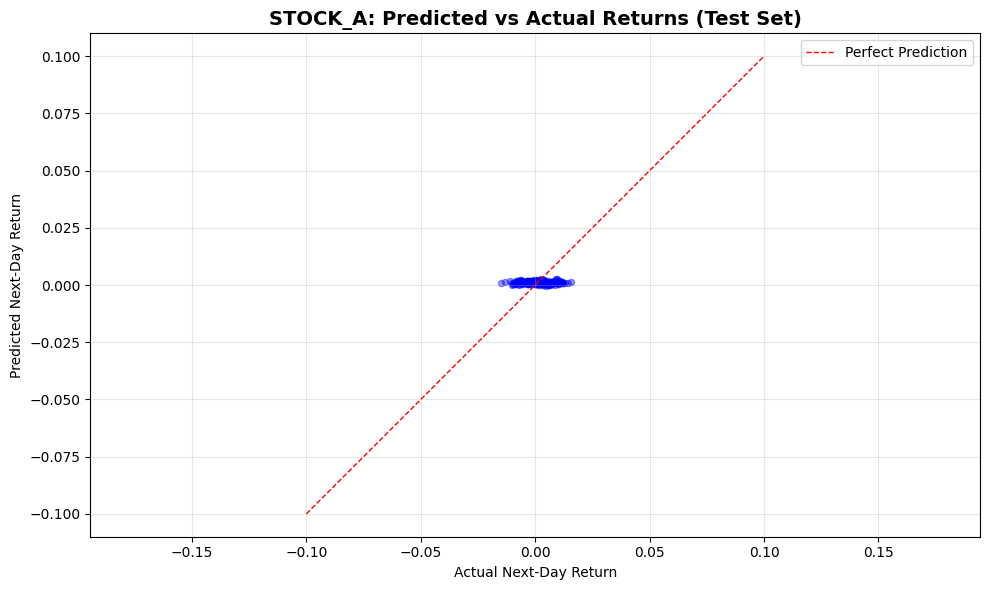


**Key Takeaway:**
- We've demonstrated proper feature construction respecting causality
- Train/test splitting respects temporal order
- Normalization uses only training data statistics
- Even low R² can be meaningful with proper risk management
- Later chapters will cover advanced ML models and deep learning


In [ ]:

# %% [markdown]
# ## 7. Implications for Feature Engineering and ML
#
# Now we build features from our synthetic data, demonstrating:
# - Time-aware construction (no look-ahead)
# - Proper train/test splitting
# - Feature normalization using only past data

# %% [markdown]
# ### 7.1 Constructing Features

# %% [code]
def compute_momentum(prices, horizon):
    """Compute momentum: (price[t] - price[t-horizon]) / price[t-horizon]"""
    momentum = []
    for i in range(len(prices)):
        if i < horizon:
            momentum.append(None)
        else:
            momentum.append((prices[i] - prices[i-horizon]) / prices[i-horizon])
    return momentum


def compute_realized_volatility(returns, window, annualization=252):
    """Compute rolling standard deviation of returns."""
    return rolling_volatility(returns, window, annualization)


def compute_relative_volume(volumes, window):
    """Compute current volume / average volume over window."""
    rel_vol = []
    for i in range(len(volumes)):
        if i < window:
            rel_vol.append(None)
        else:
            avg_vol = sum(volumes[i-window:i]) / window
            rel_vol.append(volumes[i] / avg_vol if avg_vol > 0 else 1.0)
    return rel_vol


def compute_hl_range_pct(ohlc_list):
    """Compute (high - low) / close for each day."""
    ranges = []
    for ohlc in ohlc_list:
        hl_range = (ohlc['high'] - ohlc['low']) / ohlc['close']
        ranges.append(hl_range)
    return ranges


# Build feature set for STOCK_A
print("Computing features for STOCK_A...")

features = {
    'momentum_20d': compute_momentum(stock_a_prices, 20),
    'volatility_20d': compute_realized_volatility(stock_a_simple, 20),
    'relative_volume': compute_relative_volume(stock_a_volumes, 20),
    'hl_range_pct': compute_hl_range_pct(market_data['STOCK_A']['ohlc'])
}

# Target: next-day return (shift by -1)
target = stock_a_simple[1:] + [None]  # Shift forward by 1

# Combine into feature matrix (list of dicts)
feature_matrix = []
for i in range(len(stock_a_prices)):
    row = {'day': i}
    # Add features
    for feat_name, feat_values in features.items():
        row[feat_name] = feat_values[i]
    # Add target
    row['target'] = target[i]

    feature_matrix.append(row)

print(f"Feature matrix constructed: {len(feature_matrix)} rows")
print(f"\nFirst 25 rows:")
for i in range(25):
    print(f"  Day {i}: {feature_matrix[i]}")

# %% [markdown]
# ### 7.2 Time-Aware Train/Test Split

# %% [code]
# Remove rows with any None values
feature_matrix_clean = []
for row in feature_matrix:
    if all(row[k] is not None for k in row.keys() if k != 'day'):
        feature_matrix_clean.append(row)

print(f"After removing None values: {len(feature_matrix_clean)} rows")

# Split 70/30
split_idx = int(len(feature_matrix_clean) * 0.7)

train_data = feature_matrix_clean[:split_idx]
test_data = feature_matrix_clean[split_idx:]

print(f"\nTrain set: {len(train_data)} observations (days {train_data[0]['day']} to {train_data[-1]['day']})")
print(f"Test set:  {len(test_data)} observations (days {test_data[0]['day']} to {test_data[-1]['day']})")

# %% [markdown]
# ### 7.3 Feature Normalization (No Look-Ahead)

# %% [code]
def compute_mean_std(data, feature_names):
    """Compute mean and std for each feature using training data only."""
    stats = {}
    for feat in feature_names:
        values = [row[feat] for row in data]
        stats[feat] = {
            'mean': mean(values),
            'std': std(values)
        }
    return stats


def normalize_features(data, stats, feature_names):
    """Z-score normalize features using pre-computed statistics."""
    normalized = []
    for row in data:
        new_row = row.copy()
        for feat in feature_names:
            val = row[feat]
            mu = stats[feat]['mean']
            sigma = stats[feat]['std']
            new_row[feat] = (val - mu) / sigma if sigma > 0 else 0.0
        normalized.append(new_row)
    return normalized


feature_names = ['momentum_20d', 'volatility_20d', 'relative_volume', 'hl_range_pct']

# Fit on train only
train_stats = compute_mean_std(train_data, feature_names)

print("Feature normalization statistics (from training data):")
for feat, stats_dict in train_stats.items():
    print(f"  {feat:20s}: mean={stats_dict['mean']:10.6f}, std={stats_dict['std']:10.6f}")

# Normalize both train and test
train_normalized = normalize_features(train_data, train_stats, feature_names)
test_normalized = normalize_features(test_data, train_stats, feature_names)

print(f"\nNormalized features (first 5 train rows):")
for i in range(5):
    print(f"  {train_normalized[i]}")

# %% [markdown]
# ### 7.4 Simple Predictive Model (Placeholder)

# %% [code]
# Simple linear regression from scratch
def train_linear_regression(X_train, y_train):
    """
    Train linear regression using closed-form solution.
    X_train: list of lists (each inner list is one observation's features)
    y_train: list of floats (targets)

    Returns:
    --------
    coefficients : list of float (including intercept as first element)
    """
    # Add intercept term
    X = [[1.0] + list(row) for row in X_train]

    # Convert to numpy for matrix operations
    X_np = np.array(X)
    y_np = np.array(y_train)

    # Closed-form: beta = (X'X)^-1 X'y
    XtX = X_np.T @ X_np
    Xty = X_np.T @ y_np
    beta = np.linalg.solve(XtX, Xty)

    return beta.tolist()


def predict_linear(X, coefficients):
    """Make predictions using learned coefficients."""
    predictions = []
    for row in X:
        # Add intercept
        x_with_intercept = [1.0] + list(row)
        pred = sum(coef * x for coef, x in zip(coefficients, x_with_intercept))
        predictions.append(pred)
    return predictions


# Prepare X and y
X_train = [[row[feat] for feat in feature_names] for row in train_normalized]
y_train = [row['target'] for row in train_normalized]

X_test = [[row[feat] for feat in feature_names] for row in test_normalized]
y_test = [row['target'] for row in test_normalized]

# Train
print("\nTraining linear regression model...")
coefficients = train_linear_regression(X_train, y_train)

print(f"Learned coefficients:")
print(f"  Intercept: {coefficients[0]:.6f}")
for i, feat in enumerate(feature_names):
    print(f"  {feat:20s}: {coefficients[i+1]:.6f}")

# Predict
y_train_pred = predict_linear(X_train, coefficients)
y_test_pred = predict_linear(X_test, coefficients)

# Evaluate
def r_squared(y_true, y_pred):
    """Compute R^2."""
    ss_res = sum((yt - yp) ** 2 for yt, yp in zip(y_true, y_pred))
    y_mean = mean(y_true)
    ss_tot = sum((yt - y_mean) ** 2 for yt in y_true)
    return 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0

def mse(y_true, y_pred):
    """Compute mean squared error."""
    return sum((yt - yp) ** 2 for yt, yp in zip(y_true, y_pred)) / len(y_true)

train_r2 = r_squared(y_train, y_train_pred)
test_r2 = r_squared(y_test, y_test_pred)
train_mse_val = mse(y_train, y_train_pred)
test_mse_val = mse(y_test, y_test_pred)

print(f"\nLinear Regression Results:")
print(f"{'Set':<10} {'R²':<12} {'MSE':<15}")
print(f"{'-'*37}")
print(f"{'Train':<10} {train_r2:>11.4f} {train_mse_val:>14.6f}")
print(f"{'Test':<10} {test_r2:>11.4f} {test_mse_val:>14.6f}")

# %% [code]
# Scatter plot of predictions vs actuals
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_test, y_test_pred, alpha=0.4, s=20, color='blue')
ax.plot([-0.1, 0.1], [-0.1, 0.1], 'r--', linewidth=1, label='Perfect Prediction')
ax.set_xlabel('Actual Next-Day Return')
ax.set_ylabel('Predicted Next-Day Return')
ax.set_title('STOCK_A: Predicted vs Actual Returns (Test Set)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axis('equal')
plt.tight_layout()
plt.show()

print("\n**Key Takeaway:**")
print("- We've demonstrated proper feature construction respecting causality")
print("- Train/test splitting respects temporal order")
print("- Normalization uses only training data statistics")
print("- Even low R² can be meaningful with proper risk management")
print("- Later chapters will cover advanced ML models and deep learning")

##10.CHECKLIST AND CONCLUSIONS

**The Practitioner's Data Quality Checklist**

Before deploying any trading strategy—whether a simple momentum rule or a sophisticated deep learning model—you must interrogate your data with systematic rigor. The following checklist distills decades of practitioner wisdom into actionable questions. Print it. Laminate it. Refer to it every time you touch a new dataset.

**Source and Provenance**

Where did this data come from? The source determines reliability, latency, and legal rights. Exchange data is authoritative but expensive. Vendor data is convenient but may have errors or adjustments you don't control. Internal data requires careful validation. Free data often comes with hidden costs—survivorship bias, questionable adjustments, or unclear terms of use. Document your source. Understand who stands behind the data and what guarantees they provide (usually none).

Is the data validated and audited? Financial data vendors rarely guarantee accuracy. They provide data "as is" with liability disclaimers. This means you must validate everything yourself. Cross-reference against alternative sources. Check for obvious errors. Build monitoring systems that alert you to anomalies. The absence of obvious problems doesn't mean the data is clean—it means you haven't looked hard enough.

What is the latency? Real-time data, delayed data, and end-of-day data are fundamentally different products with different use cases. Real-time data supports high-frequency strategies but costs more and requires robust infrastructure. Delayed data (15-20 minutes) is useless for most systematic trading. End-of-day data suffices for daily and lower-frequency strategies but can't support intraday analysis. Know your latency and match it to your strategy's horizon.

**Price Definitions and Adjustments**

Are prices adjusted for corporate actions? Splits, dividends, and other corporate actions create discontinuities in price series. Unadjusted prices show these as artificial jumps. Adjusted prices smooth them out but create their own problems—historical adjusted prices change when new dividends are announced, making backtests non-reproducible. Understand which adjustment methodology your data uses. For equities, "adjusted close" is standard, but the adjustment factor calculation varies across vendors.

What exactly is "close"? This sounds trivial but isn't. Is it the last trade price? The official closing auction price? A volume-weighted average over the last minutes of trading? Different definitions matter for execution modeling and can create basis between your backtest and live trading. Futures markets have settlement prices distinct from last trade prices. Bond markets may use evaluated pricing rather than actual transactions.

How are gaps handled? Markets close overnight, over weekends, and on holidays. Corporate news often breaks when markets are closed, creating overnight gaps between close and next open. Does your data explicitly mark non-trading periods, or does it simply skip them? Gaps complicate return calculations and risk models—an overnight gap of 10% is not the same as a 10% move during continuous trading.

**Corporate Actions and Market Microstructure**

How are dividends, splits, and mergers represented? Some datasets adjust all historical prices when dividends occur. Others provide separate dividend time series that you must handle explicitly. Stock splits require ratio adjustments. Mergers and acquisitions create survivorship issues—does the acquired company disappear from your universe? These aren't edge cases; they're regular occurrences that will break naïve strategies.

Are non-trading days explicitly marked? Futures markets have different holiday calendars than equity markets. International markets observe different holidays. When you iterate through your time index, you need to know whether an asset was actually tradeable or simply missing from your dataset. Confusing the two creates phantom signals and execution impossibilities.

Is there timezone consistency? If you trade across multiple markets or include global assets, timezone management becomes critical. Is everything in UTC? Local exchange time? Are timestamps mark-to-market time or trade time? Misaligned timestamps create artificial lead-lag relationships and spurious correlations.

**Data Quality and Integrity**

Have outliers been identified and handled? We demonstrated this with synthetic corruptions—bad ticks happen in real data constantly. Vendors sometimes provide "cleaned" data, but their cleaning rules may not match your needs. Build your own outlier detection. Implement multiple methods (z-score, percentage change limits, cross-asset consistency checks). Log everything you flag or modify.

Are there stale prices? In illiquid assets, reported prices may not reflect actual trades. The "last trade" might be hours or days old. Stale prices create artificial autocorrelation and understate volatility. Check bid-ask spreads and volume alongside prices. If volume is zero and the price hasn't moved, you're looking at a stale quote, not a stable asset.

How is missing data handled? Every dataset has gaps—holidays, halted stocks, data transmission failures, delisted securities. Does your vendor forward-fill? Interpolate? Leave gaps? Each choice has implications. Forward-filling creates artificial flat returns. Interpolation invents prices that never existed. Gaps complicate analysis but preserve reality. Document your choice and implement it consistently.

What about survivorship bias? Historical databases often include only currently active securities, excluding bankruptcies, delistings, and mergers. This creates upward bias in backtest performance—you're testing on winners. Survivorship-free data is expensive and harder to work with, but essential for realistic strategy evaluation. If you can't afford survivorship-free data, at least acknowledge the bias and stress-test your strategies accordingly.

**Frequency, Sampling, and Timestamps**

What is the native frequency? Tick data, 1-second bars, 1-minute bars, and daily bars are different products. Higher frequency means more data, more noise, and more infrastructure complexity. Match frequency to strategy horizon—don't use tick data for a monthly rebalancing strategy, and don't use daily data for a market-making algorithm.

How are bars aggregated? Time-based bars (fixed intervals) are most common, but volume-based bars (each bar represents fixed volume) and tick-based bars (each bar represents fixed number of trades) can reduce microstructure noise. Understand your bar construction methodology—it affects OHLC interpretation and statistical properties.

Is the timestamp the bar open or close? This matters for execution modeling. If timestamps mark bar close, the open price of that bar occurred at the previous timestamp. Misunderstanding this creates one-period look-ahead bias. Some vendors timestamp bars at open, others at close. Document which you have.

**Reproducibility and Versioning**

Can you regenerate this dataset? Data vendors update their databases—they fix errors, adjust for new corporate actions, and occasionally change methodologies. If you can't reproduce the exact dataset you used for backtesting, you can't verify live trading results against historical expectations. Download and archive your data. Version control it like code.

Are transformations documented? Every calculation you perform—returns, adjustments, filters, imputations—should be documented and versioned. Six months from now, when your strategy behaves unexpectedly, you need to trace every transformation from raw data to final features. Comments in code aren't enough; maintain a data processing log.

**Legal and Compliance**

Do you have the right to use this data? Market data licenses are complex and restrictive. Exchange data often prohibits redistribution, derived data products, or certain use cases. Vendor agreements may restrict geographic deployment or require additional fees for production use. Read your agreements. Violating data licenses can result in lawsuits and exchange bans.

Are there redistribution restrictions? If you build models or analytics for clients, can you share the underlying data? Can you publish research using this data? Most licenses prohibit redistribution. Some prohibit even showing the data on screens visible to unlicensed users.

**Conclusion: Data as Foundation**

This notebook began with a simple premise: before you can build anything in algorithmic trading, you must understand market data deeply. We've now completed that journey, working from first principles to practical implementation.

**What We've Accomplished**

We generated synthetic market data with realistic properties—drift, volatility clustering, jumps, correlated volume, and cross-asset dependencies. We implemented the market data tensor in multiple representations using pure Python. We calculated returns in various forms and understood when each definition matters. We explored volume-volatility relationships and intraday patterns. We verified the three fundamental stylised facts: fat tails, volatility clustering, and cross-sectional dependence. We corrupted clean data and implemented cleaning procedures. Finally, we built features properly, respecting temporal causality and avoiding look-ahead bias.

Every calculation was transparent. Every data structure was explicit. Every trade-off was discussed. You now understand market data not as a black box that "just works" but as a complex, structured object that requires careful handling at every step.

**Why This Matters**

The best machine learning model in the world cannot overcome bad data. A sophisticated neural network trained on corrupt, biased, or poorly preprocessed market data will produce sophisticated nonsense. Conversely, simple models applied to clean, well-understood data can generate real trading profits.

Data quality determines your ceiling. You cannot backtest accurately on biased data. You cannot measure risk correctly on data with bad ticks. You cannot avoid overfitting when your train/test split leaks information. Every downstream failure in algorithmic trading—from spectacular backtest-to-live divergence to catastrophic risk blowups—traces back to data problems.

This is why we spent an entire chapter on market data before touching a single trading strategy or ML model. Foundations matter. Rushing to "interesting" topics like deep learning and reinforcement learning without understanding your data guarantees failure.

**The Synthetic Data Advantage**

Working with synthetic data taught us something real data cannot: what ground truth looks like. We encoded specific mechanisms—GARCH volatility, volume-volatility correlation, cross-asset dependence—and then observed their manifestations. This builds intuition impossible to develop from real data alone, where the true DGP is unknown and possibly non-stationary.

When you eventually work with real market data (and you must—synthetic data is a training ground, not a destination), you'll recognize patterns immediately. You'll see fat tails and think "excess kurtosis from our GARCH process." You'll see volatility clustering and remember our autocorrelation analysis. You'll check for look-ahead bias reflexively because we drilled proper feature construction into your practice.

**Moving Forward**

The next chapters build on this foundation. Chapter 03 explores advanced feature engineering—how to extract signal from the noisy data we now understand. Chapter 04 covers classical time series models like ARIMA and GARCH. Chapter 05 introduces factor models and cross-sectional analysis. Chapters 06+ progress through machine learning, deep learning, and reinforcement learning.

But everything—every model, every backtest, every optimization—rests on the data foundation we built here. When those advanced models fail (and they will), you'll debug by returning to these fundamentals: Is my data clean? Are my features properly constructed? Did I leak information? Am I respecting temporal causality?

**Final Thoughts**

Market data is messy, high-dimensional, and unforgiving. It rewards careful, systematic thinking and punishes shortcuts mercilessly. But it's also fascinating—a window into how millions of humans negotiate value, manage risk, and respond to information in real-time.

Treat your data with respect. Question it constantly. Validate everything. Document your assumptions. Version your transformations. Build monitoring systems. Stay paranoid.

The markets are adversarial. Your competitors have clean data, robust infrastructure, and institutional knowledge. Your only sustainable edge is discipline—in data handling, in modeling, in risk management, in every detail.

You've now built that discipline from first principles. You understand what market data is, how it's structured, what can go wrong, and how to handle it properly. This knowledge is your foundation. Build carefully on it.

Welcome to algorithmic trading. The real work starts now.

